In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import seaborn as sns

In [41]:
'''
function to check that tail_base was also inside arm for a list of nose frames
'''
def check_tail_entry(df_mouse_boolean, list_of_frames, ti):
    f=0; #tail entry frame, if valid
    fc=0;
    entered=False;
    for l in list_of_frames:
        if df_mouse_boolean.iloc[l,ti]==1:
            f=l;
            fc = fc+1;
        if fc>5:
            f = f-5;
            entered= True;
            break;
    return entered, f;

In [42]:
'''
function to check when tail_base exited
'''
def check_tail_exit(df_mouse_boolean, startf, ti):
    xf=0; #tail entry frame, if valid
    fc=0;
    end= False;
    for l in range(startf, len(df_mouse_boolean)):
        if df_mouse_boolean.iloc[l,ti]==0:
            xf = l;
            fc = fc+1;
        else:
            fc=0;
        if fc>5:
            xf=l-5;
            break;
    return xf;

In [72]:
'''
function to exclude repeat entries (when for a new nose entry, tail base is already inside arm)
'''
def check_repeat_entries(df_entries_stats_sorted):
    df_valid_entries_stats_sorted= df_entries_stats_sorted.drop_duplicates(subset=['Exit Frame'], keep='first')
    return df_valid_entries_stats_sorted;

In [186]:
'''
main function will itirate through all frames for each nose inside arm X - from mouse_boolean.csv
then call function to validate if entry is valid (tail is also entered for more than 5 frames) - returns True
then once True, calculate entry latency - time for tail base to fully enter from nose sucessful entry
then from the moment tail enters calculate duration - until tail leave
calculate movement of nose and tail during the duration
then calculate exit latency - time for tail base to fully exit from nose sucessful exit

That will produce table as follows:
    entry frame    exit frame    duration   nose mov nose velocity  tail mov  tail velocity   entry latency   exit latency  nose entry frame  nose exit frame (both for later directionality purposes)  
A
A
A
B
B
C
C
D
D
E
E
E
'''
def valid_entries_stats(df_mouse_boolean, mouse_id):
    # 11 nose in A, 12 nose in B, ....
    entries = [];
    entry_frame=[];
    exit_frame=[];
    duration=[];
    entry_latency=[];
    exit_latency=[];
    nose_entry_frame=[];
    nose_exit_frame=[];

    for arm in range(11, 16):
        temp_ent = [];
        for frame in range(0, (len(df_mouse_boolean)-1)):
            if df_mouse_boolean.iloc[frame,arm]==1:
                temp_end = temp_ent.append(frame);
            else:
                if temp_ent: #if list is not empty
                    valid, tail_entry = check_tail_entry(df_mouse_boolean, temp_ent, arm+20);
                    if valid: # if tail_base is 1 for any
                        #check that it's not a subentry in an already recorded entry
                        #if exit_frame: # not the first entry 
                            #if df_mouse_boolean.iloc[temp_ent[0],arm+20]==0: #tail should not inside for new nose entry                  
                                if arm==11:
                                    entries.append('A');
                                elif arm==12:
                                    entries.append('B');
                                elif arm==13:
                                    entries.append('C');                        
                                elif arm==14:
                                    entries.append('D');
                                elif arm==15:
                                    entries.append('E');
                                    
                                entry_frame.append(tail_entry);
                                tail_exit = check_tail_exit(df_mouse_boolean, temp_ent[-1], arm+20);
                                exit_frame.append(tail_exit);
                                dur =  (tail_exit-tail_entry+1)/30; #duration in s
                                duration.append(dur);
                                nose_entry_frame.append(temp_ent[0]);
                                nose_exit_frame.append(temp_ent[-1]);
                                ent_lat = (tail_entry-temp_ent[0]+1)/30;
                                entry_latency.append(ent_lat);
                                exit_lat = (tail_exit-temp_ent[-1]+1)/30;
                                exit_latency.append(exit_lat);

        
                    temp_ent = []; #reset for next entry vals
        
    valid_entries_stats ={'Arm Entry':entries, 'Entry Frame':entry_frame, 'Exit Frame':exit_frame, 'Duration':duration, 
                          'Entry Latency':entry_latency, 'Exit Latency':exit_latency, 
                          'Nose Entry Frame':nose_entry_frame, 'Nose Exit Frame':nose_exit_frame}
    df_valid_entries_stats = pd.DataFrame(valid_entries_stats);
    df_valid_entries_stats.to_csv(mouse_id+'_entry_stats.csv');
    df_valid_entries_stats_s = df_valid_entries_stats.sort_values(by='Entry Frame');
    df_valid_entries_stats_sorted = check_repeat_entries(df_valid_entries_stats_s)
    df_valid_entries_stats_sorted = df_valid_entries_stats_sorted.reset_index(drop=True);
    df_valid_entries_stats_sorted.to_csv(mouse_id+'_entry_stats_sorted.csv');
    return df_valid_entries_stats, df_valid_entries_stats_sorted;


In [55]:
list = []

In [58]:
not list

True

In [44]:
'''
function just for the movement stats, 
entry frame and exit frame used for entry nose mov and vel and entry tail mov and vel
'''
def get_mov_stats(df_mouse_features, entry, exit, feature_i):
    total_mov=0;
    for m in df_mouse_features.iloc[entry:exit, feature_i]:
        total_mov = total_mov+ m;
    return total_mov;

In [45]:
'''
function to get frames in between and give back a list of coefficients for each arm
'''
def get_coeff(df_features, start, end):
    a_count=0;
    b_count=0;
    c_count=0;
    d_count=0;
    e_count=0;
    none_count=0;
    for i in range(start, end+1):
        none=0
        if df_features.iloc[i, -5]:
            a_count=a_count+1;
        else:
            none=none+1;
        if df_features.iloc[i, -4]:
            b_count=b_count+1;
        else:
            none=none+1;
        if df_features.iloc[i, -3]:
            c_count=c_count+1;
        else:
            none=none+1;        
        if df_features.iloc[i, -2]:
            d_count=d_count+1;
        else:
            none=none+1;            
        if df_features.iloc[i, -1]:
            e_count=e_count+1;
        else:
            none=none+1;
        if none==5:
            none_count=none_count+1;
    tot = a_count+b_count+c_count+d_count+e_count+none_count;
    a_coeff = a_count/tot;
    b_coeff = b_count/tot;
    c_coeff = c_count/tot;
    d_coeff = d_count/tot;
    e_coeff = e_count/tot;
    return a_coeff, b_coeff, c_coeff, d_coeff, e_coeff;

In [123]:
'''
this function will itirate through all entries in order of nose exit frame
call function to calculate time in the middle from nose exit to the next nose entry as duration in middle
calculate movement and velocity for that as well
and then call function to calculate directionality coefficients (from features csv) for those frames and return so that table is ordered as:

    time duration in middle before entry   mov middle velocity middle direct coeff A   direct coeff B   direct coeff C   direct coeff D   direct coeff E
A
B
D
E
C
A
D
B
E
'''
def all_other_stats(df_entries_sorted, df_mouse_features, mouse_id):
    entries = df_entries_sorted.iloc[:, 0]
    
    arm_nose_movement=[];
    arm_nose_velocity=[];
    arm_tail_movement=[];
    arm_tail_velocity=[];    

    middle_duration=[0]
    middle_nose_movement=[0];
    middle_nose_velocity=[0];
    middle_tail_movement=[0];
    middle_tail_velocity=[0];

    direct_coeff_A=[0];
    direct_coeff_B=[0];
    direct_coeff_C=[0];
    direct_coeff_D=[0];
    direct_coeff_E=[0];

    
    for ent_i in range(0, len(df_entries_sorted)):
        
        nose_arm_entry = df_entries_sorted.iloc[ent_i, 6];
        nose_arm_exit = df_entries_sorted.iloc[ent_i, 7];
        n_feature_i = df_mouse_features_sa78m1.columns.get_loc('Movement_mouse_nose');
        a_nose_mov = get_mov_stats(df_mouse_features, nose_arm_entry, nose_arm_exit, n_feature_i); 
        arm_nose_movement.append(a_nose_mov);
        a_nose_vel = a_nose_mov/df_entries_sorted.iloc[ent_i, 3]; #divide movement by the duration
        arm_nose_velocity.append(a_nose_vel);
        arm_entry = df_entries_sorted.iloc[ent_i, 1];
        arm_exit = df_entries_sorted.iloc[ent_i, 2];

        tail_arm_entry = df_entries_sorted.iloc[ent_i, 1];
        tail_arm_exit = df_entries_sorted.iloc[ent_i, 2];
        t_feature_i=df_mouse_features_sa78m1.columns.get_loc('Movement_mouse_tail_base');
        a_tail_mov = get_mov_stats(df_mouse_features, tail_arm_entry, tail_arm_exit, t_feature_i); 
        arm_tail_movement.append(a_tail_mov);
        a_tail_vel = a_tail_mov/df_entries_sorted.iloc[ent_i, 3]; #divide movement by the duration
        arm_tail_velocity.append(a_tail_vel);


        #now for all middle calculations, those always begin in ent2 (all the time between ent2 and ent1 - as video will always begin with mouse already in ent1)
        if ent_i!=0:
            n_start = df_entries_sorted.iloc[ent_i-1, 7];
            n_end = nose_arm_entry;
            m_n_dur = (n_end-n_start+1)/30
            
            m_nose_mov = get_mov_stats(df_mouse_features, n_start, n_end, n_feature_i);
            middle_nose_movement.append(m_nose_mov);
            m_nose_vel = m_nose_mov/m_n_dur;
            middle_nose_velocity.append(m_nose_vel);

            t_start = df_entries_sorted.iloc[ent_i-1, 2];
            t_end = tail_arm_entry;
            m_dur = (t_end-t_start+1)/30
            middle_duration.append(m_dur);
            
            m_tail_mov = get_mov_stats(df_mouse_features, t_start, t_end, t_feature_i);
            middle_tail_movement.append(m_tail_mov);
            m_tail_vel = m_tail_mov/m_dur;            
            middle_tail_velocity.append(m_tail_vel);

            ca, cb, cc, cd, ce = get_coeff(df_mouse_features, n_start, n_end);
            
            direct_coeff_A.append(ca);
            direct_coeff_B.append(cb);
            direct_coeff_C.append(cc);
            direct_coeff_D.append(cd);
            direct_coeff_E.append(ce);

    other_stats ={'Arm Entry':entries, 'Arm Nose Movement':arm_nose_movement, 'Arm Nose Velocity':arm_nose_velocity,
                  'Arm Tail Movement':arm_tail_movement, 'Arm Tail Velocity':arm_tail_velocity,'Middle Duration':middle_duration,
                  'Middle Nose Movement':middle_nose_movement, 'Middle Nose Velocity':middle_nose_velocity, 
                  'Middle Tail Movement':middle_tail_movement, 'Middle Tail Velocity':middle_tail_velocity, 
                  'Directionality Coefficiet A':direct_coeff_A, 'Directionality Coefficiet B':direct_coeff_B, 
                  'Directionality Coefficiet C':direct_coeff_C, 'Directionality Coefficiet D':direct_coeff_D, 
                  'Directionality Coefficiet E':direct_coeff_E}
    df_other_stats = pd.DataFrame(other_stats);
    df_other_stats = df_other_stats.reset_index(drop=True);
    df_other_stats.to_csv(mouse_id+'_other_stats.csv');
    return df_other_stats;


In [47]:
'''
this function will just get the coefficients of the current arm entered and the past two so in ABC at C look at coeff for C and coeff for A
    current coeff  skip arm coeff   current coeff time proportional   skip arm coeff time proportional
A    value for A     value for none
B    value for B     value for none
C    value for C    value for A
D    value for D    value for B
E    value for E    value for C
A
C
'''
def add_lag_dir_coefficients(df_other_stats, mouse_id):
    entries = df_other_stats.iloc[:,0];
    
    current_coeff=[0];
    lag_2_coeff=[0];

    current_coeff_time=[0];
    lag_2_coeff_time=[0];

    for ent in range(1, len(df_other_stats)):
        ind=0;
        let = df_other_stats.iloc[ent,0];
        if let=='E':
            ind=-1
        elif let=='D':
            ind=-2
        elif let=='C':
            ind=-3
        elif let=='B':
            ind=-4
        elif let=='A':
            ind=-5
        
        if ent>=2:
            temp_c= df_other_stats.iloc[ent,ind];
            current_coeff.append(temp_c);

            temp_c_t = temp_c*df_other_stats.iloc[ent,5]; #coeff * time in middle
            current_coeff_time.append(temp_c_t);
            
            lag_ind=0;
            lag_let = df_other_stats.iloc[ent-2,0];
            if lag_let=='E':
                lag_ind=-1
            elif lag_let=='D':
                lag_ind=-2
            elif lag_let=='C':
                lag_ind=-3
            elif lag_let=='B':
                lag_ind=-4
            elif lag_let=='A':
                lag_ind=-5
            
            temp_l= df_other_stats.iloc[ent,lag_ind];
            lag_2_coeff.append(temp_l); 

            temp_l_t = temp_l*df_other_stats.iloc[ent,5]; #coeff * time in middle for current entry
            lag_2_coeff_time.append(temp_l_t);
            
        else:
            temp_c= df_other_stats.iloc[ent,ind];
            current_coeff.append(temp_c);
            
            temp_c_t = temp_c*df_other_stats.iloc[ent,5]; #coeff * time in middle
            current_coeff_time.append(temp_c_t);

            lag_2_coeff.append(0);
            lag_2_coeff_time.append(0);
        
    lagged_coeff ={'Arm Entry':entries, 'Current Coeff':current_coeff, 'Lagged 2 Coeff':lag_2_coeff, 
                   'Current Coeff Time Proportional':current_coeff_time, 'Lagged 2 Time Proportional':lag_2_coeff_time}
    df_lagged_coeff = pd.DataFrame(lagged_coeff);
    df_lagged_coeff = df_lagged_coeff.reset_index(drop=True);
    df_lagged_coeff.to_csv(mouse_id+'_lagged_coeff.csv');
    return df_lagged_coeff;


In [48]:
def check_args(args):
    '''
    function checks whether list of arguments are unique
    returns boolean
    '''
    sequence=[];
    for arg in args:
        sequence.append(arg.lower());
    isunique = len(sequence)==len(set(sequence)) # set() removes repetitions
    return isunique #True for unique sequence, False if repetition

In [49]:
'''
this function will be to return output
'''
def get_output(*args):
    for i in range(len(args)-1):
        output = len(args);
        if check_args(args[i:]):
            output = output-i;
            break;
        else:
            output = 1;
    return output;


In [182]:
'''
this function will set ouput as the choice level (5,4,3,2, and 1)
A   1      
B   2 
D   3
E   4
C   5
A   5
D   4
B   5
E   5
and will finally create all info needed for the next step - classifier
'''
def add_choice_output(df_entry_stats_ordered, df_other_stats, df_lagged_coeff, mouse_id):
    entries = df_entry_stats_ordered.iloc[:,0];
    duration = df_entry_stats_ordered.iloc[:,3];
    entry_latency = df_entry_stats_ordered.iloc[:,4];
    exit_latency = df_entry_stats_ordered.iloc[:,5];
    arm_nose_movement = df_other_stats.iloc[:,1];
    arm_nose_velocity = df_other_stats.iloc[:,2];
    arm_tail_movement = df_other_stats.iloc[:,3];
    arm_tail_velocity = df_other_stats.iloc[:,4];
    middle_duration = df_other_stats.iloc[:,5];
    middle_nose_movement = df_other_stats.iloc[:,6];
    middle_nose_velocity = df_other_stats.iloc[:,7];
    middle_tail_movement = df_other_stats.iloc[:,8];
    middle_tail_velocity = df_other_stats.iloc[:,9];
    current_coeff = df_lagged_coeff.iloc[:, 1];
    lagged_2_coeff = df_lagged_coeff.iloc[:, 2];
    current_coeff_time = df_lagged_coeff.iloc[:, 3];
    lagged_2_coeff_time = df_lagged_coeff.iloc[:, 4];

    choice_output=[1];
    
    for ind in range(1, len(entries)):
        ent1 = df_entry_stats_ordered.iloc[ind-4,0]
        ent2 = df_entry_stats_ordered.iloc[ind-3,0]
        ent3 = df_entry_stats_ordered.iloc[ind-2,0]
        ent4 = df_entry_stats_ordered.iloc[ind-1,0]
        ent5 = df_entry_stats_ordered.iloc[ind,0]

        if ind > 3:
            temp_output = get_output(ent1, ent2, ent3, ent4, ent5)
            choice_output.append(temp_output);
        elif ind > 2:
            temp_output = get_output(ent2, ent3, ent4, ent5)
            choice_output.append(temp_output);        
        elif ind >1:
            temp_output = get_output(ent3, ent4, ent5)
            choice_output.append(temp_output);
        elif ind >0:
            temp_output = get_output(ent4, ent5)
            choice_output.append(temp_output);
    
    everything_stats ={'Arm Entry':entries, 'Duration':duration, 'Entry Latency':entry_latency, 'Exit Latency':exit_latency,
                       'Arm Nose Movement':arm_nose_movement, 'Arm Nose Velocity':arm_nose_velocity,
                  'Arm Tail Movement':arm_tail_movement, 'Arm Tail Velocity':arm_tail_velocity,'Middle Duration':middle_duration,
                  'Middle Nose Movement':middle_nose_movement, 'Middle Nose Velocity':middle_nose_velocity, 
                  'Middle Tail Movement':middle_tail_movement, 'Middle Tail Velocity':middle_tail_velocity, 
                  'Current Coeff':current_coeff, 'Lagged 2 Coeff':lagged_2_coeff, 
                  'Current Coeff Time Proportional':current_coeff_time, 'Lagged 2 Time Proportional':lagged_2_coeff_time, 'Choice Output':choice_output}
    
    len(entries)
    len(choice_output)
    len(everything_stats)

    
    df_everything_stats = pd.DataFrame(everything_stats);
    df_everything_stats = df_everything_stats.reset_index(drop=True);
    df_everything_stats.to_csv(mouse_id+'_everything_stats.csv');
    return df_everything_stats;


# starting some tests with mouse sa78m1, sa78m3, sa88m1, sa190m1, sa79m5, sa78m5

In [187]:
df_mouse_boolean_sa78m1 = pd.read_csv('sa78m1_2_21_25_boolean.csv')

In [188]:
df_mouse_boolean_sa78m3 = pd.read_csv('sa78m3_2_21_25_boolean.csv')

In [189]:
df_mouse_boolean_sa88m1 = pd.read_csv('sa88m1_2_21_25_boolean.csv')

In [190]:
df_mouse_boolean_sa190m1 = pd.read_csv('sa190m1_2_21_25_boolean.csv')

In [191]:
#df_mouse_boolean_sa79m5 = pd.read_csv('sa79m5_2_21_25_boolean.csv')

In [192]:
df_mouse_boolean_sa78m5 = pd.read_csv('sa78m5_2_21_25_boolean.csv')

In [193]:
df_mouse_entry_stats_sa78m1, df_mouse_entry_stats_sorted_sa78m1 = valid_entries_stats(df_mouse_boolean_sa78m1, 'sa78m1')

In [194]:
df_mouse_entry_stats_sa78m3, df_mouse_entry_stats_sorted_sa78m3 = valid_entries_stats(df_mouse_boolean_sa78m3, 'sa78m3')

In [195]:
df_mouse_entry_stats_sa88m1, df_mouse_entry_stats_sorted_sa88m1 = valid_entries_stats(df_mouse_boolean_sa88m1, 'sa88m1')

In [196]:
df_mouse_entry_stats_sa190m1, df_mouse_entry_stats_sorted_sa190m1 = valid_entries_stats(df_mouse_boolean_sa190m1, 'sa190m1')

In [197]:
#df_mouse_entry_stats_sa79m5, df_mouse_entry_stats_sorted_sa79m5 = valid_entries_stats(df_mouse_boolean_sa79m5, 'sa79m5')

In [198]:
df_mouse_entry_stats_sa78m5, df_mouse_entry_stats_sorted_sa78m5 = valid_entries_stats(df_mouse_boolean_sa78m5, 'sa78m5')

In [199]:
df_mouse_features_sa78m1 = pd.read_csv('sa78m1_2_21_25_features.csv')

In [200]:
df_mouse_features_sa78m3 = pd.read_csv('sa78m3_2_21_25_features.csv')

In [201]:
df_mouse_features_sa88m1 = pd.read_csv('sa88m1_2_21_25_features.csv')

In [202]:
df_mouse_features_sa190m1 = pd.read_csv('sa190m1_2_21_25_features.csv')

In [203]:
#df_mouse_features_sa79m5 = pd.read_csv('sa79m5_2_21_25_features.csv')

In [204]:
df_mouse_features_sa78m5 = pd.read_csv('sa78m5_2_21_25_features.csv')

In [205]:
df_other_stats_sa78m1 = all_other_stats(df_mouse_entry_stats_sorted_sa78m1, df_mouse_features_sa78m1, 'sa78m1')

In [206]:
df_other_stats_sa78m3 = all_other_stats(df_mouse_entry_stats_sorted_sa78m3, df_mouse_features_sa78m3, 'sa78m3')

In [207]:
df_other_stats_sa88m1 = all_other_stats(df_mouse_entry_stats_sorted_sa88m1, df_mouse_features_sa88m1, 'sa88m1')

In [208]:
df_other_stats_sa190m1 = all_other_stats(df_mouse_entry_stats_sorted_sa190m1, df_mouse_features_sa190m1, 'sa190m1')

In [209]:
#df_other_stats_sa79m5 = all_other_stats(df_mouse_entry_stats_sorted_sa79m5, df_mouse_features_sa79m5, 'sa79m5')

In [210]:
df_other_stats_sa78m5 = all_other_stats(df_mouse_entry_stats_sorted_sa78m5, df_mouse_features_sa78m5, 'sa78m5')

In [211]:
df_lagged_coeff_sa78m1 = add_lag_dir_coefficients(df_other_stats_sa78m1, 'sa78m1')

In [212]:
df_lagged_coeff_sa78m3 = add_lag_dir_coefficients(df_other_stats_sa78m3, 'sa78m3')

In [213]:
df_lagged_coeff_sa88m1 = add_lag_dir_coefficients(df_other_stats_sa88m1, 'sa88m1')

In [214]:
df_lagged_coeff_sa190m1 = add_lag_dir_coefficients(df_other_stats_sa190m1, 'sa190m1')

In [215]:
#df_lagged_coeff_sa79m5 = add_lag_dir_coefficients(df_other_stats_sa79m5, 'sa79m5')

In [216]:
df_lagged_coeff_sa78m5 = add_lag_dir_coefficients(df_other_stats_sa78m5, 'sa78m5')

In [217]:
df_everything_stats_sa78m1 = add_choice_output(df_mouse_entry_stats_sorted_sa78m1, df_other_stats_sa78m1, df_lagged_coeff_sa78m1, 'sa78m1')

In [219]:
df_everything_stats_sa78m3 = add_choice_output(df_mouse_entry_stats_sorted_sa78m3, df_other_stats_sa78m3, df_lagged_coeff_sa78m3, 'sa78m3')

In [220]:
df_everything_stats_sa88m1 = add_choice_output(df_mouse_entry_stats_sorted_sa88m1, df_other_stats_sa88m1, df_lagged_coeff_sa88m1, 'sa88m1')

In [221]:
df_everything_stats_sa190m1 = add_choice_output(df_mouse_entry_stats_sorted_sa190m1, df_other_stats_sa190m1, df_lagged_coeff_sa190m1, 'sa190m1')

In [222]:
#df_everything_stats_sa79m5 = add_choice_output(df_mouse_entry_stats_sorted_sa79m5, df_other_stats_sa79m5, df_lagged_coeff_sa79m5, 'sa79m5')

In [223]:
df_everything_stats_sa78m5 = add_choice_output(df_mouse_entry_stats_sorted_sa78m5, df_other_stats_sa78m5, df_lagged_coeff_sa78m5, 'sa78m5')

In [739]:
df_everything_stats_sa78m1['Choice Output']

0     1
1     2
2     3
3     4
4     5
5     4
6     3
7     2
8     3
9     4
10    3
11    4
12    4
13    2
14    3
15    4
16    5
17    4
18    3
19    3
20    4
21    5
Name: Choice Output, dtype: int64

# starting the classifier

# testing gradient boosting classifier from scikit

In [224]:
# gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [225]:
import polars as pl

In [226]:
pl.Config.set_fmt_str_lengths(20)

polars.config.Config

In [227]:
import polars.selectors as cs

In [228]:
df_pls_sa78m1 = pl.read_csv('sa78m1_everything_stats.csv')

In [229]:
df_pls_sa78m3 = pl.read_csv('sa78m3_everything_stats.csv')

In [230]:
df_pls_sa88m1 = pl.read_csv('sa88m1_everything_stats.csv')

In [231]:
df_pls_sa190m1 = pl.read_csv('sa190m1_everything_stats.csv')

In [232]:
#df_pls_sa79m5 = pl.read_csv('sa79m5_everything_stats.csv')

In [233]:
df_pls_sa78m5 = pl.read_csv('sa78m5_everything_stats.csv')

In [234]:
summary_sa78m1 = df_pls_sa78m1.select(cs.numeric()).describe()

In [238]:
summary_sa78m3 = df_pls_sa78m3.select(cs.numeric()).describe()

In [239]:
summary_sa88m1 = df_pls_sa88m1.select(cs.numeric()).describe()

In [240]:
summary_sa190m1 = df_pls_sa190m1.select(cs.numeric()).describe()

In [ ]:
#summary_sa79m5 = df_pls_sa79m5.select(cs.numeric()).describe()

In [241]:
summary_sa78m5 = df_pls_sa78m5.select(cs.numeric()).describe()

In [245]:
'''
function to create the lagging for all previous 4 choices
'''
def lagging_four_prev_choices(df_pls):
    lagged_df_everything_stats = df_pls.select(
    "Duration", 
    *[pl.col("Duration").shift(i).alias(f"lagged_{i}_duration") for i in [1,2,3,4]],
    "Entry Latency", 
    *[pl.col("Entry Latency").shift(i).alias(f"lagged_{i}_entry_lat") for i in [1,2,3,4]],
    "Exit Latency", 
    *[pl.col("Exit Latency").shift(i).alias(f"lagged_{i}_exit_lat") for i in [1,2,3,4]], 
    "Arm Nose Movement", 
    *[pl.col("Arm Nose Movement").shift(i).alias(f"lagged_{i}_arm_nose_mov") for i in [1,2,3,4]],
    "Arm Nose Velocity", 
    *[pl.col("Arm Nose Velocity").shift(i).alias(f"lagged_{i}_arm_nose_vel") for i in [1,2,3,4]],
    "Arm Tail Movement", 
    *[pl.col("Arm Tail Movement").shift(i).alias(f"lagged_{i}_arm_tail_mov") for i in [1,2,3,4]],
    "Arm Tail Velocity", 
    *[pl.col("Arm Tail Velocity").shift(i).alias(f"lagged_{i}_arm_tail_vel") for i in [1,2,3,4]],
    "Middle Duration", 
    *[pl.col("Middle Duration").shift(i).alias(f"lagged_{i}_mid_duration") for i in [1,2,3,4]],
    "Middle Nose Movement", 
    *[pl.col("Middle Nose Movement").shift(i).alias(f"lagged_{i}_mid_nose_mov") for i in [1,2,3,4]],
    "Middle Nose Velocity", 
    *[pl.col("Middle Nose Velocity").shift(i).alias(f"lagged_{i}_mid_nose_vel") for i in [1,2,3,4]],
    "Middle Tail Movement", 
    *[pl.col("Middle Tail Movement").shift(i).alias(f"lagged_{i}_mid_tail_mov") for i in [1,2,3,4]],
    "Middle Tail Velocity", 
    *[pl.col("Middle Tail Velocity").shift(i).alias(f"lagged_{i}_mid_tail_vel") for i in [1,2,3,4]],
    "Current Coeff", 
    *[pl.col("Current Coeff").shift(i).alias(f"lagged_{i}_cur_coeff") for i in [1,2,3,4]],
    "Lagged 2 Coeff", 
    *[pl.col("Lagged 2 Coeff").shift(i).alias(f"lagged_{i}_coeff_2") for i in [1,2,3,4]],
    "Current Coeff Time Proportional", 
    *[pl.col("Current Coeff Time Proportional").shift(i).alias(f"lagged_{i}_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 2 Time Proportional", 
    *[pl.col("Lagged 2 Time Proportional").shift(i).alias(f"lagged_{i}_coeff_2_time_prop") for i in [1,2,3,4]],
    "Choice Output", 
    *[pl.col("Choice Output").shift(i).alias(f"lagged_{i}_choice_ago") for i in [1,2,3,4]]
    )
    lagged_df_everything_stats = lagged_df_everything_stats.drop_nulls()
    return lagged_df_everything_stats;

In [247]:
lagged_df_everything_stats_sa78m1 = lagging_four_prev_choices(df_pls_sa78m1)

In [248]:
lagged_df_everything_stats_sa78m3 = lagging_four_prev_choices(df_pls_sa78m3)

In [249]:
lagged_df_everything_stats_sa88m1 = lagging_four_prev_choices(df_pls_sa88m1)

In [250]:
lagged_df_everything_stats_sa190m1 = lagging_four_prev_choices(df_pls_sa190m1)

In [251]:
#lagged_df_everything_stats_sa79m5 = lagging_four_prev_choices(df_pls_sa79m5)

In [252]:
lagged_df_everything_stats_sa78m5 = lagging_four_prev_choices(df_pls_sa78m5)

In [256]:
from sklearn.preprocessing import MinMaxScaler

In [257]:
scaler = MinMaxScaler()

In [266]:
lagged_scaled_data_sa78m1 = lagged_df_everything_stats_sa78m1

In [267]:
lagged_scaled_data_sa78m3 = lagged_df_everything_stats_sa78m3

In [268]:
lagged_scaled_data_sa88m1 = lagged_df_everything_stats_sa88m1

In [269]:
lagged_scaled_data_sa190m1 = lagged_df_everything_stats_sa190m1 

In [270]:
#lagged_scaled_data_sa79m5  = lagged_df_everything_stats_sa79m5

In [271]:
lagged_scaled_data_sa78m5 = lagged_df_everything_stats_sa78m5

In [272]:
lagged_scaled_data_sa78m1[lagged_scaled_data_sa78m1.columns[:80]] = scaler.fit_transform(lagged_scaled_data_sa78m1[lagged_scaled_data_sa78m1.columns[:80]])

In [273]:
lagged_scaled_data_sa78m3[lagged_scaled_data_sa78m3.columns[:80]] = scaler.fit_transform(lagged_scaled_data_sa78m3[lagged_scaled_data_sa78m3.columns[:80]])

In [274]:
lagged_scaled_data_sa88m1[lagged_scaled_data_sa88m1.columns[:80]] = scaler.fit_transform(lagged_scaled_data_sa88m1[lagged_scaled_data_sa88m1.columns[:80]])

In [275]:
lagged_scaled_data_sa190m1[lagged_scaled_data_sa190m1.columns[:80]] = scaler.fit_transform(lagged_scaled_data_sa190m1[lagged_scaled_data_sa190m1.columns[:80]])

In [276]:
#lagged_scaled_data_sa79m5[lagged_scaled_data_sa79m5.columns[:80]] = scaler.fit_transform(lagged_scaled_data_sa79m5[lagged_scaled_data_sa79m5.columns[:80]])

In [277]:
lagged_scaled_data_sa78m5[lagged_scaled_data_sa78m5.columns[:80]] = scaler.fit_transform(lagged_scaled_data_sa78m5[lagged_scaled_data_sa78m5.columns[:80]])

In [279]:
grouped_lagged_scaled_data = pl.concat([lagged_scaled_data_sa78m1, lagged_scaled_data_sa78m3, 
                            lagged_scaled_data_sa88m1, lagged_scaled_data_sa190m1, lagged_scaled_data_sa78m5], rechunk=True)

In [511]:
grouped_lagged_scaled_data

Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,Exit Latency,lagged_1_exit_lat,lagged_2_exit_lat,lagged_3_exit_lat,lagged_4_exit_lat,Arm Nose Movement,lagged_1_arm_nose_mov,lagged_2_arm_nose_mov,lagged_3_arm_nose_mov,lagged_4_arm_nose_mov,Arm Nose Velocity,lagged_1_arm_nose_vel,lagged_2_arm_nose_vel,lagged_3_arm_nose_vel,lagged_4_arm_nose_vel,Arm Tail Movement,lagged_1_arm_tail_mov,lagged_2_arm_tail_mov,lagged_3_arm_tail_mov,lagged_4_arm_tail_mov,Arm Tail Velocity,lagged_1_arm_tail_vel,lagged_2_arm_tail_vel,lagged_3_arm_tail_vel,lagged_4_arm_tail_vel,Middle Duration,lagged_1_mid_duration,…,lagged_3_mid_nose_vel,lagged_4_mid_nose_vel,Middle Tail Movement,lagged_1_mid_tail_mov,lagged_2_mid_tail_mov,lagged_3_mid_tail_mov,lagged_4_mid_tail_mov,Middle Tail Velocity,lagged_1_mid_tail_vel,lagged_2_mid_tail_vel,lagged_3_mid_tail_vel,lagged_4_mid_tail_vel,Current Coeff,lagged_1_cur_coeff,lagged_2_cur_coeff,lagged_3_cur_coeff,lagged_4_cur_coeff,Lagged 2 Coeff,lagged_1_coeff_2,lagged_2_coeff_2,lagged_3_coeff_2,lagged_4_coeff_2,Current Coeff Time Proportional,lagged_1_cur_coeff_time_prop,lagged_2_cur_coeff_time_prop,lagged_3_cur_coeff_time_prop,lagged_4_cur_coeff_time_prop,Lagged 2 Time Proportional,lagged_1_coeff_2_time_prop,lagged_2_coeff_2_time_prop,lagged_3_coeff_2_time_prop,lagged_4_coeff_2_time_prop,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
0.020188,0.166218,0.010094,0.047779,0.098923,0.0,0.884615,0.461538,0.192308,0.0,0.246154,0.076923,0.292308,0.491803,0.333333,0.264968,0.357643,0.217816,0.259175,0.30422,0.903164,0.321935,0.895674,0.657483,0.516024,0.511125,0.543293,0.415624,0.482367,0.533361,1.0,0.345437,0.937047,0.725946,0.529948,0.031579,0.222222,…,0.373782,0.0,0.311882,0.0,0.063679,0.69027,0.0,0.825472,0.023571,0.215916,0.304232,0.0,0.665955,0.103433,0.027103,0.603231,0.0,0.0,0.0,0.577899,0.0,0.0,0.086973,0.119405,0.039084,0.577356,0.0,0.0,0.0,0.492284,0.0,0.0,5,4,3,2,1
0.03432,0.020188,0.166218,0.010094,0.047779,0.192308,0.0,0.884615,0.461538,0.4,0.492308,0.246154,0.076923,0.245902,0.483333,0.261909,0.264968,0.357643,0.217816,0.259175,0.764091,0.903164,0.321935,0.895674,0.727978,0.474897,0.511125,0.543293,0.415624,0.482367,0.812264,1.0,0.345437,0.937047,0.725946,0.021053,0.055556,…,0.357749,0.557966,0.073976,0.428059,0.0,0.063679,0.785612,0.59397,0.814269,0.023571,0.254845,0.456057,0.013828,0.665955,0.103433,0.027103,0.650582,0.495627,0.0,0.0,0.577899,0.0,0.005372,0.210826,0.119405,0.039084,0.588026,0.276545,0.0,0.0,0.492284,0.0,4,5,4,3,2
0.129206,0.03432,0.020188,0.166218,0.010094,0.038462,0.192308,0.0,0.884615,0.6,0.092308,0.492308,0.246154,0.016393,0.233333,0.413768,0.261909,0.264968,0.357643,0.217816,0.496108,0.764091,0.903164,0.321935,0.991706,0.520055,0.474897,0.511125,0.543293,0.415624,0.417565,0.812264,1.0,0.345437,0.937047,0.057895,0.037037,…,0.212092,0.546648,0.368369,0.144819,0.428059,0.0,0.3519,0.65986,0.567905,0.814269,0.027821,0.417446,0.624051,0.013828,0.665955,0.103433,0.14321,0.0,0.495627,0.0,0.0,0.577899,0.109088,0.013022,0.210826,0.119405,0.063343,0.0,0.276545,0.0,0.0,0.492284,3,4,5,4,3
0.182369,0.129206,0.03432,0.020188,0.166218,0.423077,0.038462,0.192308,0.0,0.914286,0.461538,0.092308,0.492308,0.196721,0.0,0.379217,0.413768,0.261909,0.264968,0.357643,0.306472,0.496108,0.764091,0.903164,0.356453,0.546556,0.520055,0.474897,0.511125,0.543293,0.315077,0.417565,0.812264,1.0,0.345437,0.084211,0.101852,…,1.0,0.443831,0.422522,0.495309,0.144819,0.428059,0.307823,0.553607,0.638025,0.567905,0.961078,0.239962,0.884537,0.624051,0.013828,0.665955,0.21043

In [281]:
X_grouped = grouped_lagged_scaled_data.drop("Choice Output")
y_grouped = grouped_lagged_scaled_data["Choice Output"]
print("X shape: {}\ny shape: {}".format(X_grouped.shape, y_grouped.shape))

X shape: (111, 84)
y shape: (111,)


In [282]:
from sklearn.model_selection import train_test_split

In [283]:
X_train, X_test, y_train, y_test = train_test_split(
    X_grouped, y_grouped, test_size=0.2, random_state=42
)

In [294]:
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train, y_train, random_state=0)

In [295]:
from sklearn.metrics import mean_absolute_percentage_error

In [462]:
lr_list = [0.05, 0.075, 0.1, 0.12, 0.15, 0.2, 0.25, 0.5]

In [463]:
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate=learning_rate, max_depth=5, random_state=40)
    gb_clf.fit(X_train_sub, y_train_sub)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score( X_validation_sub, y_validation_sub)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.318
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.227
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.273
Learning rate:  0.12
Accuracy score (training): 1.000
Accuracy score (validation): 0.273
Learning rate:  0.15
Accuracy score (training): 1.000
Accuracy score (validation): 0.227
Learning rate:  0.2
Accuracy score (training): 1.000
Accuracy score (validation): 0.364
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.364
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.273


In [315]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [696]:
# evaluate the model
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
# make a single prediction
yhat = model.predict(X_test)
f1 = f1_score(y_test, yhat, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.350 (0.151)
F1 score: 0.468


In [697]:
n_scores

array([0.11111111, 0.22222222, 0.66666667, 0.22222222, 0.44444444,
       0.22222222, 0.44444444, 0.33333333, 0.5       , 0.625     ,
       0.44444444, 0.44444444, 0.22222222, 0.44444444, 0.44444444,
       0.11111111, 0.22222222, 0.44444444, 0.25      , 0.25      ,
       0.55555556, 0.22222222, 0.33333333, 0.22222222, 0.33333333,
       0.55555556, 0.11111111, 0.33333333, 0.25      , 0.5       ])

In [698]:
f1

0.4683574879227052

In [334]:
yhat

array([4, 1, 3, 5, 2, 4, 4, 4, 3, 4, 2, 4, 5, 4, 3, 3, 2, 4, 2, 5, 2, 3,
       3], dtype=int64)

In [332]:
for i in y_test:
    print(i);
    

4
3
3
4
2
2
5
4
4
4
4
5
5
4
4
4
1
4
5
5
5
2
3


# changing GradientBoostingClassifier parameters

In [410]:
# changing number of trees - estimators
def get_models_est():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n, max_depth=5)
	return models

In [411]:
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [412]:
models_est =  get_models_est()

In [413]:
results_est=[]
names_est=[]

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>10 0.335 (0.135)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>50 0.335 (0.137)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>100 0.331 (0.140)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>500 0.350 (0.148)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>1000 0.354 (0.166)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>5000 0.350 (0.151)


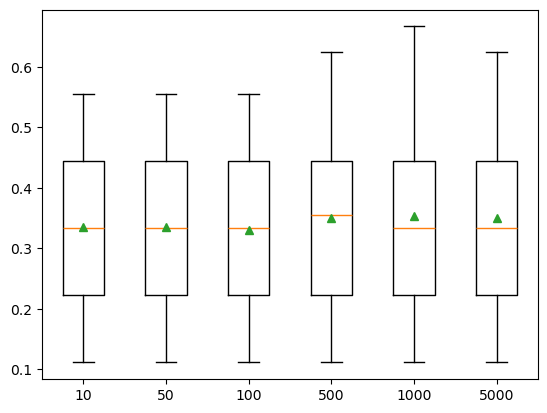

In [414]:
for name, model in models_est.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results_est.append(scores)
	names_est.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_est, labels=names_est, showmeans=True)
pyplot.show()

In [415]:
def get_models_subs():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=500, max_depth=5)
	return models

In [416]:
models_subs =  get_models_subs()

In [417]:
results_subs=[]
names_subs=[]

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.1 0.304 (0.128)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.2 0.200 (0.131)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.3 0.198 (0.138)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.4 0.242 (0.136)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.5 0.285 (0.134)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.6 0.283 (0.148)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.7 0.238 (0.130)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.8 0.332 (0.161)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.9 0.309 (0.170)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>1.0 0.369 (0.163)


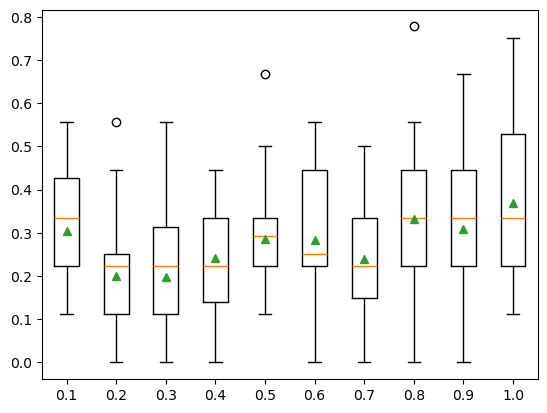

In [418]:
for name, model in models_subs.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results_subs.append(scores)
	names_subs.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_subs, labels=names_subs, showmeans=True)
pyplot.show()

In [449]:
def get_models_feat():
    models = dict()
	# explore number of features from 1 to 20
    l = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,84];
    for i in l:
        models[str(i)] = GradientBoostingClassifier(max_features=i, n_estimators=500, max_depth=5)
    return models

In [450]:
models_feat = get_models_feat()

In [451]:
results_feat=[]
names_feat=[]

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>15 0.317 (0.166)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>20 0.352 (0.158)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>25 0.362 (0.168)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>30 0.346 (0.166)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>35 0.339 (0.164)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>40 0.363 (0.163)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>45 0.345 (0.178)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>50 0.361 (0.155)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>55 0.360 (0.173)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>60 0.379 (0.162)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>65 0.375 (0.175)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>70 0.350 (0.162)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>75 0.346 (0.159)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>80 0.359 (0.169)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>84 0.373 (0.167)


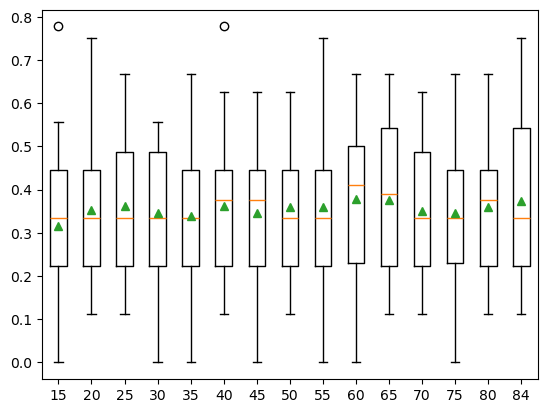

In [452]:
for name, model in models_feat.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results_feat.append(scores)
	names_feat.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_feat, labels=names_feat, showmeans=True)
pyplot.show()

In [457]:
def get_models_lr():
	models = dict()
	# define learning rates to explore
	for i in [0.005, 0.01, 0.05, 0.07, 0.085, 0.1, 0.125, 0.15, 0.18, 0.25, 0.3]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i, n_estimators=500, max_depth=5)
	return models

In [458]:
models_lr = get_models_lr()

In [459]:
results_lr=[]
names_lr=[]

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.0050 0.362 (0.186)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.0100 0.361 (0.150)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.0500 0.372 (0.150)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.0700 0.369 (0.144)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.0850 0.376 (0.158)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.1000 0.368 (0.171)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.1250 0.384 (0.166)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.1500 0.379 (0.158)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.1800 0.363 (0.159)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.2500 0.330 (0.167)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>0.3000 0.363 (0.161)


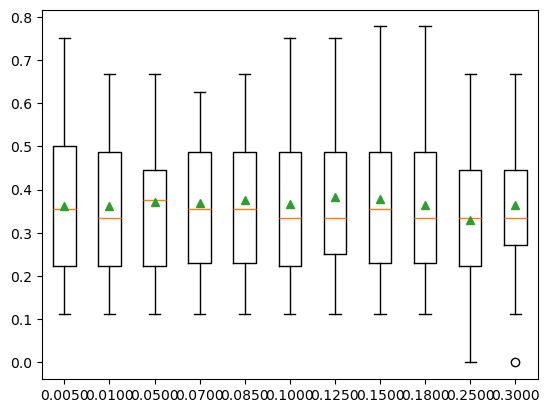

In [460]:
for name, model in models_lr.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results_lr.append(scores)
	names_lr.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_lr, labels=names_lr, showmeans=True)
pyplot.show()

In [394]:
def get_models_td():
	models = dict()
	# define max tree depths to explore between 1 and 10
	for i in range(1,8):
		models[str(i)] = GradientBoostingClassifier(max_depth=i)
	return models

In [395]:
models_td = get_models_td()

In [396]:
results_td=[]
names_td=[]

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>1 0.363 (0.114)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>2 0.350 (0.112)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>3 0.349 (0.140)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>4 0.357 (0.136)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>5 0.388 (0.181)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>6 0.339 (0.155)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>7 0.312 (0.127)


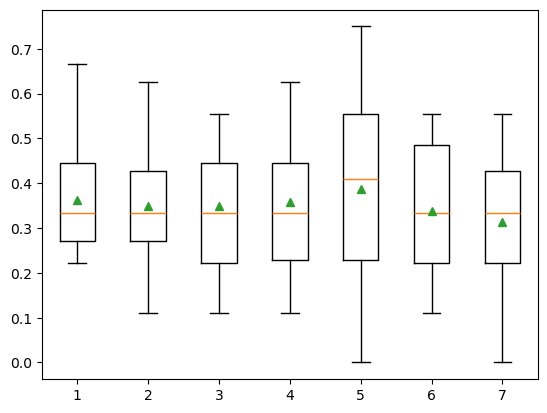

In [397]:
for name, model in models_td.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results_td.append(scores)
	names_td.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_td, labels=names_td, showmeans=True)
pyplot.show()

In [400]:
md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_features=10, max_depth=5, random_state=42)
scores = evaluate_model(md, X_train, y_train)
# store the results
results_td.append(scores)
names_td.append(name)
# summarize the performance along the way
print('%.3f (%.3f)' % (mean(scores), std(scores)))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.340 (0.159)


In [505]:
def get_kfolds_split():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(5,20):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=i, n_repeats=3, random_state=1)
    return cvs

In [506]:
results_ksp = []
names_ksp = []

In [507]:
cvs_split = get_kfolds_split()

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


>5 0.324 (0.119)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


>6 0.337 (0.107)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=7.
  warnings.warn(


>7 0.356 (0.137)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(


>8 0.367 (0.142)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=9.
  warnings.warn(


>9 0.330 (0.141)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


>10 0.341 (0.149)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=11.
  warnings.warn(


>11 0.360 (0.147)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=12.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=12.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=12.
  warnings.warn(


>12 0.314 (0.130)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=13.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=13.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=13.
  warnings.warn(


>13 0.347 (0.149)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=14.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=14.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=14.
  warnings.warn(


>14 0.344 (0.191)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=15.
  warnings.warn(


>15 0.407 (0.182)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=16.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=16.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=16.
  warnings.warn(


>16 0.367 (0.182)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=17.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=17.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=17.
  warnings.warn(


>17 0.345 (0.204)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=18.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=18.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=18.
  warnings.warn(


>18 0.382 (0.202)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=19.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=19.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=19.
  warnings.warn(


>19 0.385 (0.224)


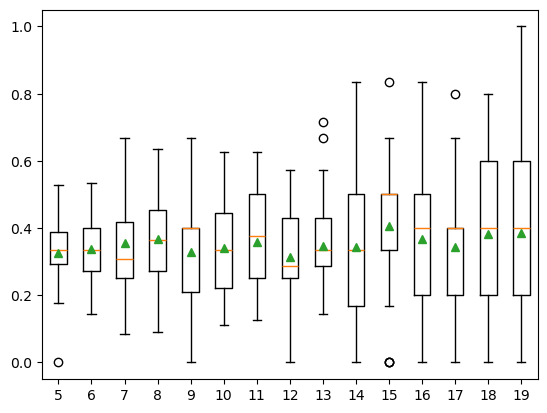

In [508]:
for name, cv in cvs_split.items():
	# evaluate the model
    md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_features=26, max_depth=5, random_state=42)
    scores = cross_val_score(md, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	# store the results
    results_ksp.append(scores)
    names_ksp.append(name)
	# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_ksp, labels=names_ksp, showmeans=True)
pyplot.show()

In [485]:
def get_kfolds_repeat():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,15):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=16, n_repeats=i, random_state=1)
    return cvs

In [486]:
results_kr = []
names_kr = []

In [487]:
cvs_r = get_kfolds_repeat()

In [489]:
for name, cv in cvs_r.items():
	# evaluate the model
    md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_depth=5, random_state=42)
    scores = cross_val_score(md, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	# store the results
    results_kr.append(scores)
    names_kr.append(name)
	# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_kr, labels=names_kr, showmeans=True)
pyplot.show()

AttributeError: 'Series' object has no attribute 'iloc'

In [ ]:
def get_crossval_repeat():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,15):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=16, n_repeats=i, random_state=1)
    return cvs

In [502]:
for i in y_train:
    if i == 1:
        print(i)

1


In [503]:
for i in y_test:
    if i == 1:
        print(i)

1


# removing all 1 as choice output

In [509]:
grouped_lagged_scaled_data_filtered = grouped_lagged_scaled_data.filter(pl.col('Choice Output') != 1)

In [510]:
grouped_lagged_scaled_data_filtered

Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,Exit Latency,lagged_1_exit_lat,lagged_2_exit_lat,lagged_3_exit_lat,lagged_4_exit_lat,Arm Nose Movement,lagged_1_arm_nose_mov,lagged_2_arm_nose_mov,lagged_3_arm_nose_mov,lagged_4_arm_nose_mov,Arm Nose Velocity,lagged_1_arm_nose_vel,lagged_2_arm_nose_vel,lagged_3_arm_nose_vel,lagged_4_arm_nose_vel,Arm Tail Movement,lagged_1_arm_tail_mov,lagged_2_arm_tail_mov,lagged_3_arm_tail_mov,lagged_4_arm_tail_mov,Arm Tail Velocity,lagged_1_arm_tail_vel,lagged_2_arm_tail_vel,lagged_3_arm_tail_vel,lagged_4_arm_tail_vel,Middle Duration,lagged_1_mid_duration,…,lagged_3_mid_nose_vel,lagged_4_mid_nose_vel,Middle Tail Movement,lagged_1_mid_tail_mov,lagged_2_mid_tail_mov,lagged_3_mid_tail_mov,lagged_4_mid_tail_mov,Middle Tail Velocity,lagged_1_mid_tail_vel,lagged_2_mid_tail_vel,lagged_3_mid_tail_vel,lagged_4_mid_tail_vel,Current Coeff,lagged_1_cur_coeff,lagged_2_cur_coeff,lagged_3_cur_coeff,lagged_4_cur_coeff,Lagged 2 Coeff,lagged_1_coeff_2,lagged_2_coeff_2,lagged_3_coeff_2,lagged_4_coeff_2,Current Coeff Time Proportional,lagged_1_cur_coeff_time_prop,lagged_2_cur_coeff_time_prop,lagged_3_cur_coeff_time_prop,lagged_4_cur_coeff_time_prop,Lagged 2 Time Proportional,lagged_1_coeff_2_time_prop,lagged_2_coeff_2_time_prop,lagged_3_coeff_2_time_prop,lagged_4_coeff_2_time_prop,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
0.020188,0.166218,0.010094,0.047779,0.098923,0.0,0.884615,0.461538,0.192308,0.0,0.246154,0.076923,0.292308,0.491803,0.333333,0.264968,0.357643,0.217816,0.259175,0.30422,0.903164,0.321935,0.895674,0.657483,0.516024,0.511125,0.543293,0.415624,0.482367,0.533361,1.0,0.345437,0.937047,0.725946,0.529948,0.031579,0.222222,…,0.373782,0.0,0.311882,0.0,0.063679,0.69027,0.0,0.825472,0.023571,0.215916,0.304232,0.0,0.665955,0.103433,0.027103,0.603231,0.0,0.0,0.0,0.577899,0.0,0.0,0.086973,0.119405,0.039084,0.577356,0.0,0.0,0.0,0.492284,0.0,0.0,5,4,3,2,1
0.03432,0.020188,0.166218,0.010094,0.047779,0.192308,0.0,0.884615,0.461538,0.4,0.492308,0.246154,0.076923,0.245902,0.483333,0.261909,0.264968,0.357643,0.217816,0.259175,0.764091,0.903164,0.321935,0.895674,0.727978,0.474897,0.511125,0.543293,0.415624,0.482367,0.812264,1.0,0.345437,0.937047,0.725946,0.021053,0.055556,…,0.357749,0.557966,0.073976,0.428059,0.0,0.063679,0.785612,0.59397,0.814269,0.023571,0.254845,0.456057,0.013828,0.665955,0.103433,0.027103,0.650582,0.495627,0.0,0.0,0.577899,0.0,0.005372,0.210826,0.119405,0.039084,0.588026,0.276545,0.0,0.0,0.492284,0.0,4,5,4,3,2
0.129206,0.03432,0.020188,0.166218,0.010094,0.038462,0.192308,0.0,0.884615,0.6,0.092308,0.492308,0.246154,0.016393,0.233333,0.413768,0.261909,0.264968,0.357643,0.217816,0.496108,0.764091,0.903164,0.321935,0.991706,0.520055,0.474897,0.511125,0.543293,0.415624,0.417565,0.812264,1.0,0.345437,0.937047,0.057895,0.037037,…,0.212092,0.546648,0.368369,0.144819,0.428059,0.0,0.3519,0.65986,0.567905,0.814269,0.027821,0.417446,0.624051,0.013828,0.665955,0.103433,0.14321,0.0,0.495627,0.0,0.0,0.577899,0.109088,0.013022,0.210826,0.119405,0.063343,0.0,0.276545,0.0,0.0,0.492284,3,4,5,4,3
0.182369,0.129206,0.03432,0.020188,0.166218,0.423077,0.038462,0.192308,0.0,0.914286,0.461538,0.092308,0.492308,0.196721,0.0,0.379217,0.413768,0.261909,0.264968,0.357643,0.306472,0.496108,0.764091,0.903164,0.356453,0.546556,0.520055,0.474897,0.511125,0.543293,0.315077,0.417565,0.812264,1.0,0.345437,0.084211,0.101852,…,1.0,0.443831,0.422522,0.495309,0.144819,0.428059,0.307823,0.553607,0.638025,0.567905,0.961078,0.239962,0.884537,0.624051,0.013828,0.665955,0.21043

In [512]:
X_grouped_filter = grouped_lagged_scaled_data_filtered.drop("Choice Output")
y_grouped_filter = grouped_lagged_scaled_data_filtered["Choice Output"]
print("X shape: {}\ny shape: {}".format(X_grouped_filter.shape, y_grouped_filter.shape))

X shape: (109, 84)
y shape: (109,)


In [514]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_grouped_filter, y_grouped_filter, test_size=0.2, random_state=42)

In [294]:
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train, y_train, random_state=0)

In [295]:
from sklearn.metrics import mean_absolute_percentage_error

In [462]:
lr_list = [0.05, 0.075, 0.1, 0.12, 0.15, 0.2, 0.25, 0.5]

In [463]:
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=500, learning_rate=learning_rate, max_depth=5, random_state=40)
    gb_clf.fit(X_train_sub, y_train_sub)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score( X_validation_sub, y_validation_sub)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.318
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.227
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.273
Learning rate:  0.12
Accuracy score (training): 1.000
Accuracy score (validation): 0.273
Learning rate:  0.15
Accuracy score (training): 1.000
Accuracy score (validation): 0.227
Learning rate:  0.2
Accuracy score (training): 1.000
Accuracy score (validation): 0.364
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.364
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.273


In [315]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [515]:
# evaluate the model
model = GradientBoostingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_f, y_train_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingClassifier()
model.fit(X_train_f, y_train_f)
# make a single prediction
yhatf = model.predict(X_test_f)

Accuracy: 0.307 (0.139)


In [516]:
n_scores

array([0.55555556, 0.33333333, 0.22222222, 0.22222222, 0.55555556,
       0.44444444, 0.55555556, 0.25      , 0.25      , 0.125     ,
       0.44444444, 0.22222222, 0.44444444, 0.44444444, 0.22222222,
       0.22222222, 0.33333333, 0.125     , 0.375     , 0.25      ,
       0.33333333, 0.11111111, 0.11111111, 0.33333333, 0.33333333,
       0.44444444, 0.33333333, 0.375     , 0.        , 0.25      ])

In [520]:
for y in y_test_f:
    print(y)

5
3
3
2
3
3
5
4
5
4
4
2
5
3
4
2
2
2
5
5
5
2


In [517]:
yhat

array([4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 5, 3, 2, 5, 3, 4, 4, 5, 3, 3],
      dtype=int64)

In [547]:
# changing number of trees - estimators
def get_models_est():
	models = dict()
	# define number of trees to consider
	n_trees = [1, 3, 5, 10, 50, 100, 500, 1000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n, max_depth=4)
	return models

In [548]:
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [549]:
models_est =  get_models_est()

In [550]:
results_est=[]
names_est=[]

>1 0.370 (0.098)
>3 0.370 (0.158)
>5 0.355 (0.148)
>10 0.359 (0.141)
>50 0.338 (0.149)
>100 0.343 (0.161)
>500 0.316 (0.132)
>1000 0.328 (0.140)


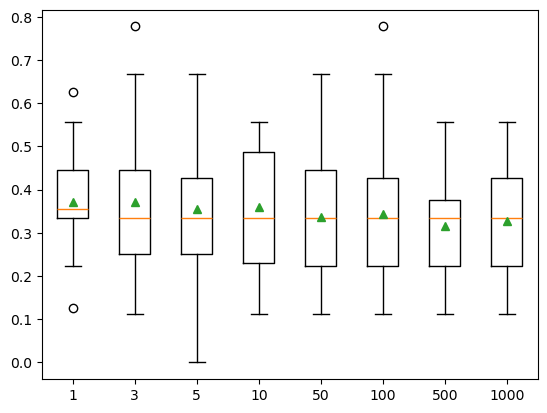

In [551]:
for name, model in models_est.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_f, y_train_f)
	# store the results
	results_est.append(scores)
	names_est.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_est, labels=names_est, showmeans=True)
pyplot.show()

In [569]:
def get_models_subs():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=10, max_depth=4)
	return models

In [570]:
models_subs =  get_models_subs()

In [571]:
results_subs=[]
names_subs=[]

>0.1 0.279 (0.139)
>0.2 0.281 (0.178)
>0.3 0.349 (0.141)
>0.4 0.273 (0.146)
>0.5 0.305 (0.160)
>0.6 0.300 (0.158)
>0.7 0.298 (0.134)
>0.8 0.350 (0.142)
>0.9 0.343 (0.151)
>1.0 0.366 (0.149)


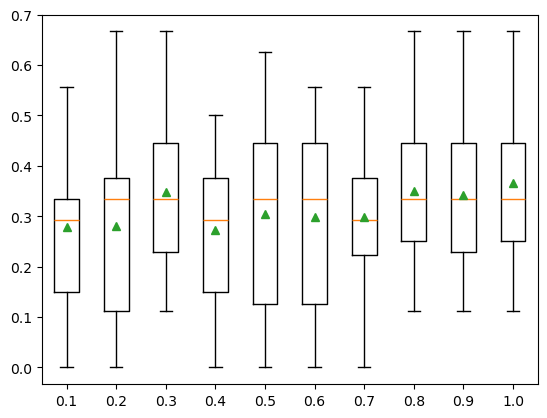

In [572]:
for name, model in models_subs.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_f, y_train_f)
	# store the results
	results_subs.append(scores)
	names_subs.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_subs, labels=names_subs, showmeans=True)
pyplot.show()

In [642]:
def get_models_feat():
    models = dict()
	# explore number of features from 1 to 20
    l = [15,20,25,30,35,40,45,50,55,60,65,70,75,80,84];
    for i in l:
        models[str(i)] = GradientBoostingClassifier(max_features=i, learning_rate=0.07, n_estimators=10, max_depth=4)
    return models

In [643]:
models_feat = get_models_feat()

In [644]:
results_feat=[]
names_feat=[]

>15 0.331 (0.149)
>20 0.331 (0.139)
>25 0.354 (0.137)
>30 0.372 (0.166)
>35 0.371 (0.139)
>40 0.380 (0.140)
>45 0.356 (0.169)
>50 0.351 (0.130)
>55 0.386 (0.164)
>60 0.388 (0.141)
>65 0.401 (0.166)
>70 0.338 (0.191)
>75 0.364 (0.165)
>80 0.381 (0.148)
>84 0.338 (0.170)


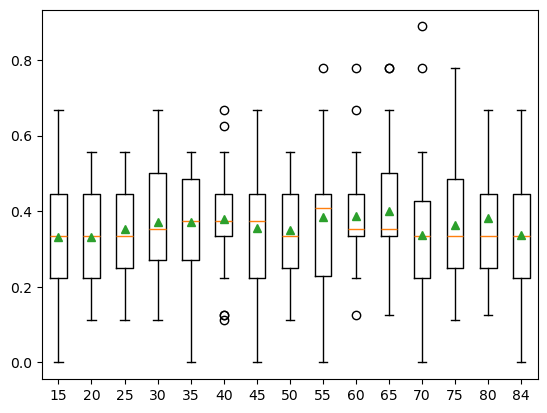

In [645]:
for name, model in models_feat.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_f, y_train_f)
	# store the results
	results_feat.append(scores)
	names_feat.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_feat, labels=names_feat, showmeans=True)
pyplot.show()

In [653]:
def get_models_lr():
	models = dict()
	# define learning rates to explore
	for i in [0.001, 0.005, 0.01, 0.05, 0.07, 0.085, 0.1, 0.125, 0.15, 0.18, 0.25, 0.3, 0.5]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i, n_estimators=1000, max_depth=4)
	return models

In [654]:
models_lr = get_models_lr()

In [655]:
results_lr=[]
names_lr=[]

>0.0010 0.339 (0.158)
>0.0050 0.373 (0.141)
>0.0100 0.316 (0.148)
>0.0500 0.301 (0.169)
>0.0700 0.305 (0.129)
>0.0850 0.300 (0.141)
>0.1000 0.316 (0.148)
>0.1250 0.274 (0.131)
>0.1500 0.281 (0.125)
>0.1800 0.312 (0.137)
>0.2500 0.280 (0.137)
>0.3000 0.313 (0.122)
>0.5000 0.289 (0.106)


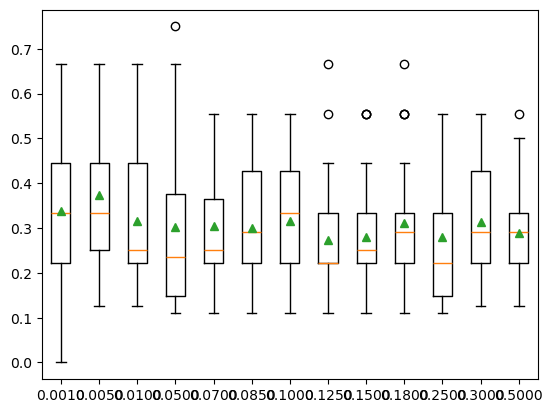

In [656]:
for name, model in models_lr.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_f, y_train_f)
	# store the results
	results_lr.append(scores)
	names_lr.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_lr, labels=names_lr, showmeans=True)
pyplot.show()

In [531]:
def get_models_td():
	models = dict()
	# define max tree depths to explore between 1 and 10
	for i in range(1,8):
		models[str(i)] = GradientBoostingClassifier(max_depth=i)
	return models

In [532]:
models_td = get_models_td()

In [533]:
results_td=[]
names_td=[]

>1 0.306 (0.139)
>2 0.290 (0.131)
>3 0.299 (0.140)
>4 0.339 (0.143)
>5 0.336 (0.147)
>6 0.328 (0.161)
>7 0.310 (0.119)


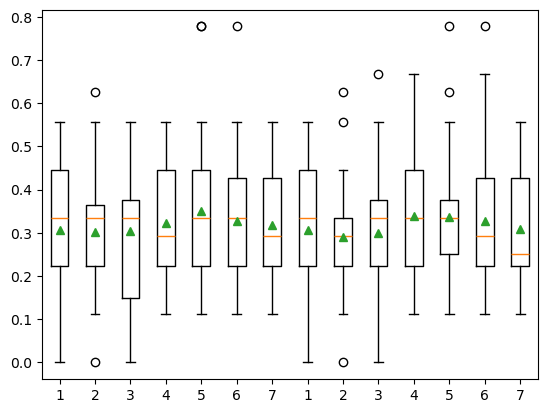

In [535]:
for name, model in models_td.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_f, y_train_f)
	# store the results
	results_td.append(scores)
	names_td.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_td, labels=names_td, showmeans=True)
pyplot.show()

In [400]:
md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_features=10, max_depth=5, random_state=42)
scores = evaluate_model(md, X_train, y_train)
# store the results
results_td.append(scores)
names_td.append(name)
# summarize the performance along the way
print('%.3f (%.3f)' % (mean(scores), std(scores)))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.340 (0.159)


In [661]:
def get_kfolds_split():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(3,13):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=i, n_repeats=3, random_state=1)
    return cvs

In [662]:
results_ksp = []
names_ksp = []

In [663]:
cvs_split = get_kfolds_split()

>3 0.299 (0.078)
>4 0.337 (0.055)
>5 0.227 (0.070)
>6 0.347 (0.139)
>7 0.323 (0.105)
>8 0.309 (0.109)
>9 0.280 (0.131)
>10 0.300 (0.143)
>11 0.294 (0.146)
>12 0.323 (0.174)


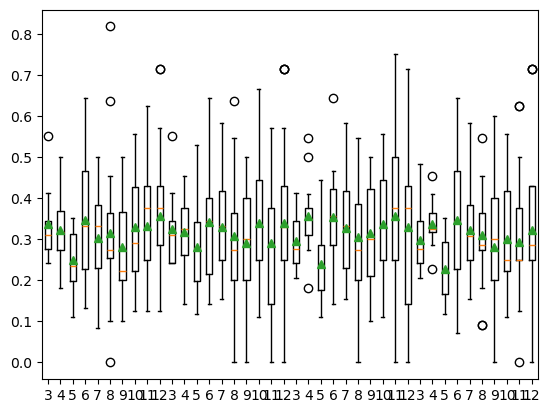

In [667]:
for name, cv in cvs_split.items():
	# evaluate the model
    #md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_features=35, max_depth=4, random_state=42)
    md =  GradientBoostingClassifier(learning_rate = 0.05, n_estimators=500, max_depth=4, random_state=42)
    scores = cross_val_score(md, X_train_f, y_train_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	# store the results
    results_ksp.append(scores)
    names_ksp.append(name)
	# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_ksp, labels=names_ksp, showmeans=True)
pyplot.show()

In [672]:
def get_kfolds_repeat():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,15):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=6, n_repeats=i, random_state=1)
    return cvs

In [673]:
results_kr = []
names_kr = []

In [674]:
cvs_r = get_kfolds_repeat()

In [675]:
for name, cv in cvs_r.items():
	# evaluate the model
    md =  GradientBoostingClassifier(learning_rate = 0.005, n_estimators=500, max_depth=4, random_state=42)
    scores = cross_val_score(md, X_train_f, y_train_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	# store the results
    results_kr.append(scores)
    names_kr.append(name)
	# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_kr, labels=names_kr, showmeans=True)
pyplot.show()

>2 0.325 (0.118)
>3 0.320 (0.107)
>4 0.341 (0.111)
>5 0.342 (0.108)
>6 0.335 (0.109)
>7 0.340 (0.105)
>8 0.334 (0.118)
>9 0.329 (0.124)
>10 0.333 (0.128)
>11 0.330 (0.125)
>12 0.332 (0.124)
>13 0.329 (0.131)


exception calling callback for <Future at 0x1d42e876e50 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\Josue Regalado\anaconda3\Lib\site-packages\joblib\parallel.py", line 862, in dispatch_one_batch
    tasks = self._ready_batches.get(block=False)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Josue Regalado\anaconda3\Lib\queue.py", line 168, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Josue Regalado\anaconda3\Lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\Josue Regalado\anaconda3\Lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\Josue Regalado\anaconda3\Lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
           ^

KeyboardInterrupt: 

In [ ]:
def get_crossval_repeat():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,15):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=16, n_repeats=i, random_state=1)
    return cvs

In [694]:
from sklearn.metrics import f1_score

In [695]:
# evaluate the model
mdf = GradientBoostingClassifier(learning_rate = 0.1, n_estimators=50, max_depth=4, random_state=45)
cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=4, random_state=2)
n_scores = cross_val_score(mdf, X_train_f, y_train_f, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
mdf.fit(X_train_f, y_train_f)
# make a single prediction
yhatfil = mdf.predict(X_test_f)
f1 = f1_score(y_test_f, yhatfil, average='weighted')
print('F1 score: %.3f' % (f1))


Accuracy: 0.322 (0.126)
F1 score: 0.333


In [691]:
yhatfil

array([4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 5, 3, 3, 5, 3, 5, 4, 5, 5, 3],
      dtype=int64)

In [689]:
for y in y_test_f:
    print(y)

5
3
3
2
3
3
5
4
5
4
4
2
5
3
4
2
2
2
5
5
5
2


In [162]:
mpl.rcParams['figure.figsize'] =(20,50)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

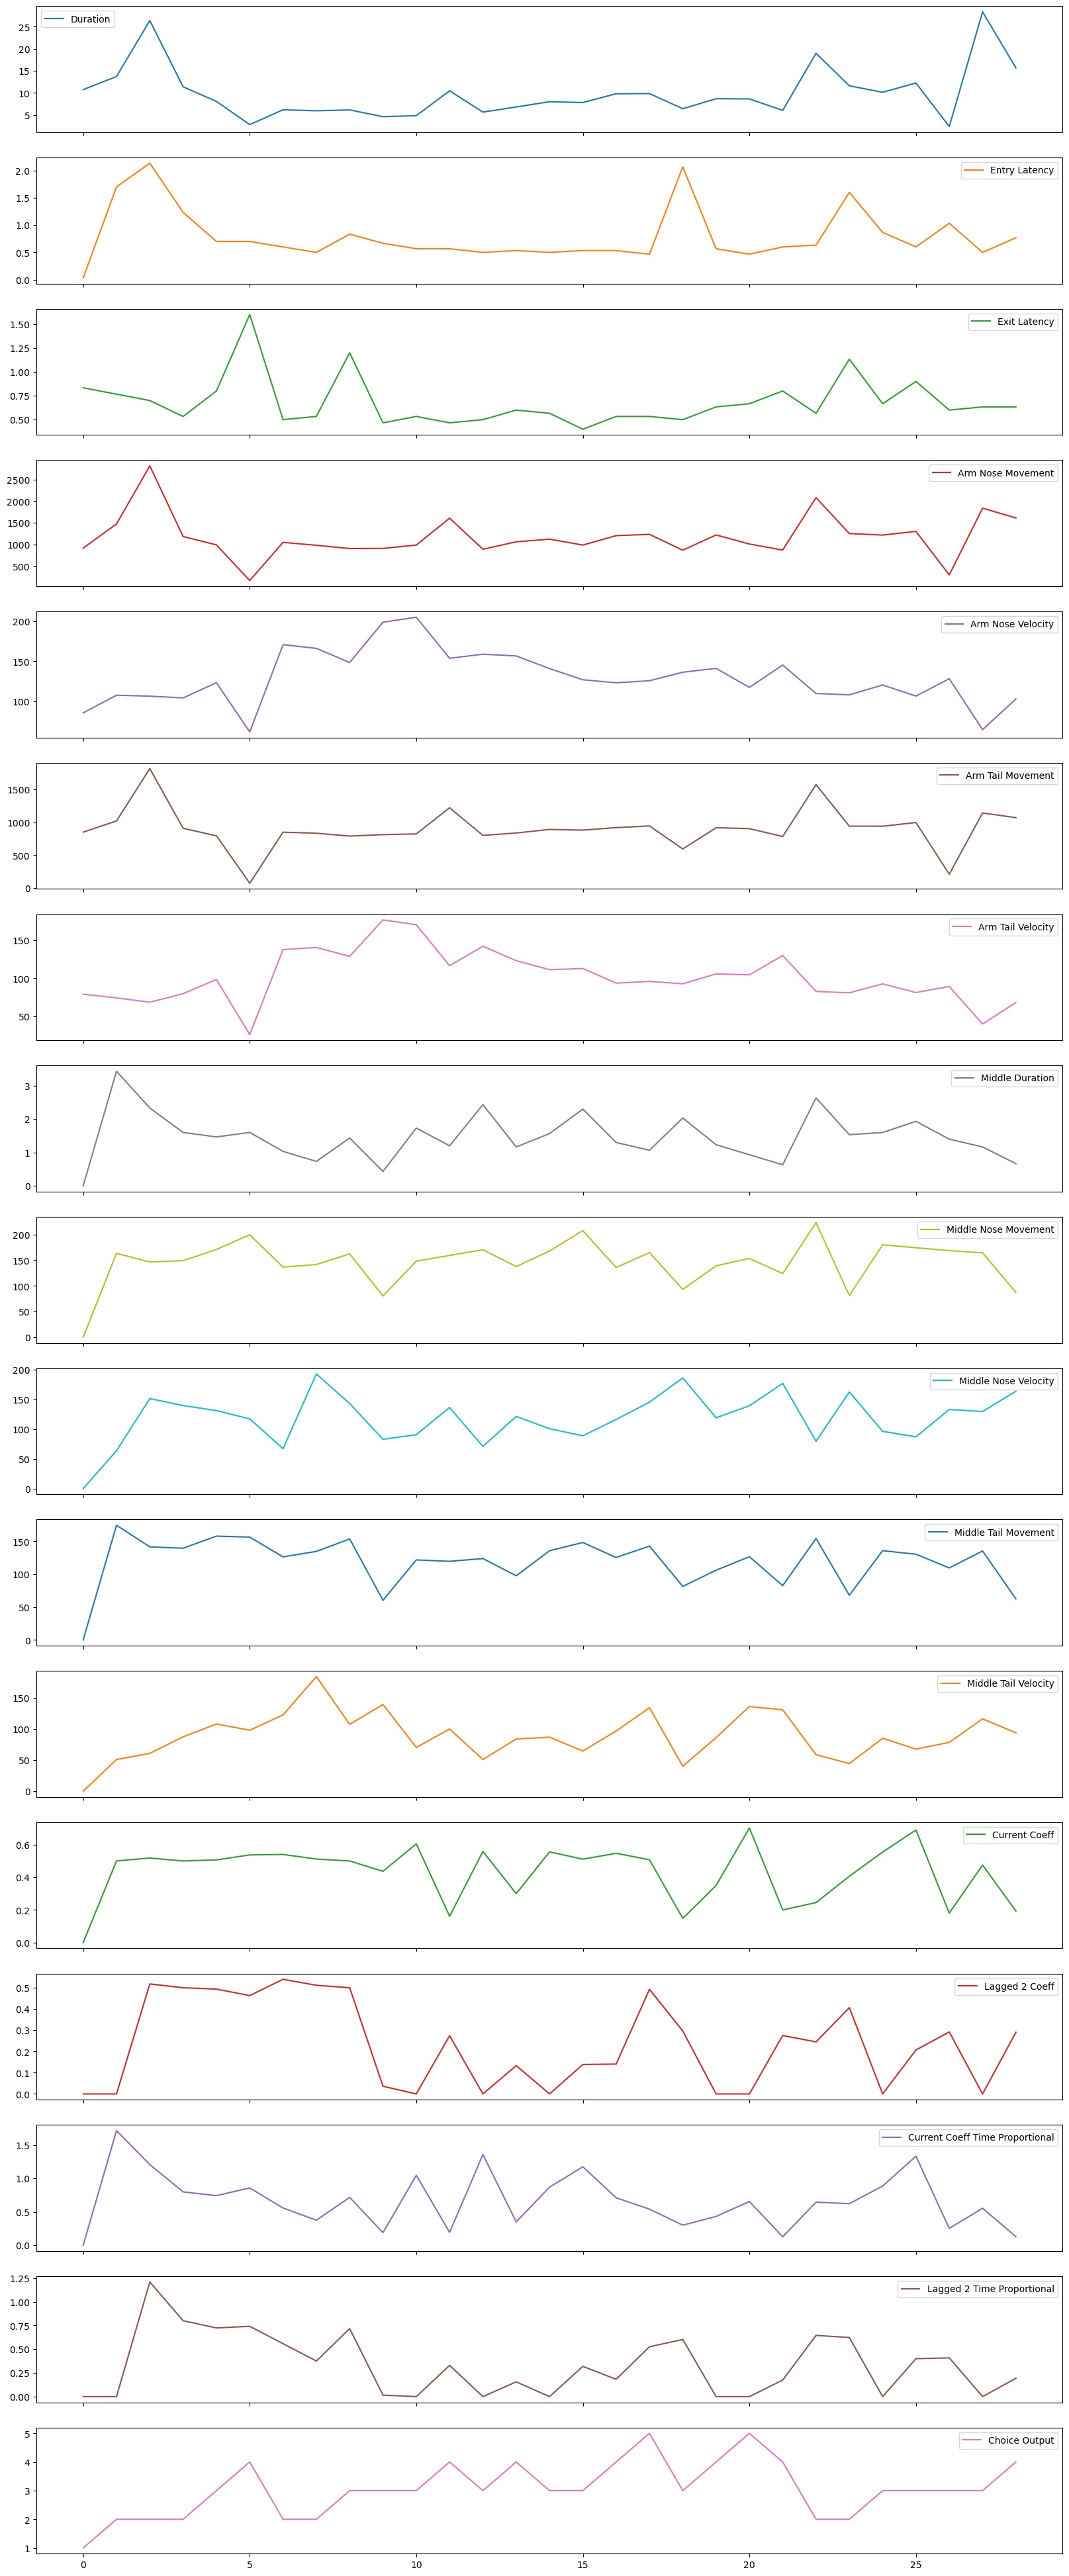

In [163]:
data_sa190m1[:].plot(subplots=True)

In [165]:
# gradient boosting for classification in scikit-learn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot

In [164]:
df_everything_stats_sa190m1 = pd.read_csv('sa190m1_021425_everything_stats.csv')

In [166]:
df_everything_stats_sa190m1

,Unnamed: 0,Arm Entry,Duration,Entry Latency,Exit Latency,Arm Nose Movement,Arm Nose Velocity,Arm Tail Movement,Arm Tail Velocity,Middle Duration,Middle Nose Movement,Middle Nose Velocity,Middle Tail Movement,Middle Tail Velocity,Current Coeff,Lagged 2 Coeff,Current Coeff Time Proportional,Lagged 2 Time Proportional,Choice Output
0,23,E,10.733333,0.033333,0.833333,919.976359,85.712083,849.142965,79.112699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,5,B,13.700000,1.700000,0.766667,1475.543289,107.703890,1018.819090,74.366357,3.433333,163.291706,63.620145,174.580726,50.848755,0.500000,0.000000,1.716667,0.000000,2
2,24,E,26.400000,2.133333,0.700000,2812.888840,106.548820,1814.022088,68.712958,2.333333,146.488270,151.539589,141.721231,60.737670,0.517857,0.517857,1.208333,1.208333,2
3,6,B,11.366667,1.233333,0.533333,1186.693580,104.401195,907.524613,79.840875,1.600000,149.115922,139.796177,139.647194,87.279496,0.500000,0.500000,0.800000,0.800000,2
4,17,D,8.066667,0.700000,0.800000,994.138710,123.240336,793.429426,98.359020,1.466667,170.766630,131.358946,158.038115,107.753260,0.506494,0.493506,0.742857,0.723810,3
5,0,A,2.800000,0.700000,1.600000,173.834032,62.083583,73.885566,26.387702,1.600000,199.503327,117.354898,156.532020,97.832512,0.536842,0.463158,0.858947,0.741053,4
6,18,D,6.166667,0.600000,0.500000,1052.394207,170.658520,848.449765,137.586448,1.033333,136.549437,67.155461,126.456365,122.377128,0.539823,0.539823,0.557817,0.557817,2
7,1,A,5.933333,0.500000,0.533333,985.240825,166.051824,832.517025,140.311858,0.733333,141.567895,193.047129,134.768264,183.774906,0.511628,0.511628,0.375194,0.375194,2
8,12,C,6.133333,0.833333,1.200000,910.332709,148.423811,789.731078,128.760502,1.433333,162.311271,143.215827,153.741556,107.261551,0.500000,0.500000,0.716667,0.716667,3
9,19,D,4.600000,0.666667,0.466667,913.894925,198.672810,811.303838,176.370400,0.433333,80.214297,82.980307,60.275835,139.098080,0.436364,0.036364,0.189091,0.015758,3


In [167]:
import polars as pl

In [168]:
pl.Config.set_fmt_str_lengths(20)

polars.config.Config

In [169]:
import polars.selectors as cs

In [175]:
df_sa190m1_pls = pl.read_csv('sa190m1_021425_everything_stats.csv')

In [176]:
summary_sa190m1 = df_sa190m1_pls.select(cs.numeric()).describe()

In [178]:
summary_sa190m1

statistic,,Duration,Entry Latency,Exit Latency,Arm Nose Movement,Arm Nose Velocity,Arm Tail Movement,Arm Tail Velocity,Middle Duration,Middle Nose Movement,Middle Nose Velocity,Middle Tail Movement,Middle Tail Velocity,Current Coeff,Lagged 2 Coeff,Current Coeff Time Proportional,Lagged 2 Time Proportional,Choice Output
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",14.0,9.935632,0.793103,0.682759,1177.70338,129.168679,900.244063,101.490757,1.468966,145.859967,118.480889,119.124547,88.935787,0.428931,0.232868,0.667348,0.334382,3.068966
"""std""",8.514693,6.06219,0.493238,0.257062,495.327825,33.40495,317.799009,33.85731,0.71586,44.370001,42.220713,37.368945,37.198037,0.176479,0.205579,0.420164,0.327431,0.961065
"""min""",0.0,2.366667,0.033333,0.4,173.834032,62.083583,73.885566,26.387702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""25%""",7.0,6.133333,0.533333,0.533333,919.976359,107.70389,811.303838,81.017816,1.066667,136.549437,88.93647,106.141876,64.495998,0.3,0.0,0.35,0.0,2.0
"""50%""",14.0,8.633333,0.6,0.6,1065.05436,125.779952,890.147683,95.908278,1.433333,153.390707,121.483208,126.695969,86.693597,0.5,0.245033,0.645254,0.318978,3.0
"""75%""",21.0,11.366667,0.833333,0.766667,1255.305995,148.423811,943.098068,122.985309,1.733333,168.653072,143.215827,141.721231,107.75326,0.539823,0.463158,0.87037,0.602469,4.0
"""max""",28.0,28.366667,2.133333,1.6,2812.88884,204.815828,1814.022088,176.3704,3.433333,223.217763,193.047129,174.580726,183.774906,0.702128,0.539823,1.716667,1.208333,5.0


In [188]:
lagged_df_everything_stats_sa190m1 = df_sa190m1_pls.select(
    "Duration", 
    *[pl.col("Duration").shift(i).alias(f"lagged_{i}_duration") for i in [1,2,3,4]],
    "Entry Latency", 
    *[pl.col("Entry Latency").shift(i).alias(f"lagged_{i}_entry_lat") for i in [1,2,3,4]],
    "Exit Latency", 
    *[pl.col("Exit Latency").shift(i).alias(f"lagged_{i}_exit_lat") for i in [1,2,3,4]], 
    "Arm Nose Movement", 
    *[pl.col("Arm Nose Movement").shift(i).alias(f"lagged_{i}_arm_nose_mov") for i in [1,2,3,4]],
    "Arm Nose Velocity", 
    *[pl.col("Arm Nose Velocity").shift(i).alias(f"lagged_{i}_arm_nose_vel") for i in [1,2,3,4]],
    "Arm Tail Movement", 
    *[pl.col("Arm Tail Movement").shift(i).alias(f"lagged_{i}_arm_tail_mov") for i in [1,2,3,4]],
    "Arm Tail Velocity", 
    *[pl.col("Arm Tail Velocity").shift(i).alias(f"lagged_{i}_arm_tail_vel") for i in [1,2,3,4]],
    "Middle Duration", 
    *[pl.col("Middle Duration").shift(i).alias(f"lagged_{i}_mid_duration") for i in [1,2,3,4]],
    "Middle Nose Movement", 
    *[pl.col("Middle Nose Movement").shift(i).alias(f"lagged_{i}_mid_nose_mov") for i in [1,2,3,4]],
    "Middle Nose Velocity", 
    *[pl.col("Middle Nose Velocity").shift(i).alias(f"lagged_{i}_mid_nose_vel") for i in [1,2,3,4]],
    "Middle Tail Movement", 
    *[pl.col("Middle Tail Movement").shift(i).alias(f"lagged_{i}_mid_tail_mov") for i in [1,2,3,4]],
    "Middle Tail Velocity", 
    *[pl.col("Middle Tail Velocity").shift(i).alias(f"lagged_{i}_mid_tail_vel") for i in [1,2,3,4]],
    "Current Coeff", 
    *[pl.col("Current Coeff").shift(i).alias(f"lagged_{i}_cur_coeff") for i in [1,2,3,4]],
    "Lagged 2 Coeff", 
    *[pl.col("Lagged 2 Coeff").shift(i).alias(f"lagged_{i}_coeff_2") for i in [1,2,3,4]],
    "Current Coeff Time Proportional", 
    *[pl.col("Current Coeff Time Proportional").shift(i).alias(f"lagged_{i}_cur_coeff_time_prop") for i in [1,2,3,4]],
    "Lagged 2 Time Proportional", 
    *[pl.col("Lagged 2 Time Proportional").shift(i).alias(f"lagged_{i}_coeff_2_time_prop") for i in [1,2,3,4]],
    "Choice Output", 
    *[pl.col("Choice Output").shift(i).alias(f"lagged_{i}_choice_ago") for i in [1,2,3,4]]
)

In [189]:
lagged_df_everything_stats_sa190m1

Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,Exit Latency,lagged_1_exit_lat,lagged_2_exit_lat,lagged_3_exit_lat,lagged_4_exit_lat,Arm Nose Movement,lagged_1_arm_nose_mov,lagged_2_arm_nose_mov,lagged_3_arm_nose_mov,lagged_4_arm_nose_mov,Arm Nose Velocity,lagged_1_arm_nose_vel,lagged_2_arm_nose_vel,lagged_3_arm_nose_vel,lagged_4_arm_nose_vel,Arm Tail Movement,lagged_1_arm_tail_mov,lagged_2_arm_tail_mov,lagged_3_arm_tail_mov,lagged_4_arm_tail_mov,Arm Tail Velocity,lagged_1_arm_tail_vel,lagged_2_arm_tail_vel,lagged_3_arm_tail_vel,lagged_4_arm_tail_vel,Middle Duration,lagged_1_mid_duration,…,lagged_3_mid_nose_vel,lagged_4_mid_nose_vel,Middle Tail Movement,lagged_1_mid_tail_mov,lagged_2_mid_tail_mov,lagged_3_mid_tail_mov,lagged_4_mid_tail_mov,Middle Tail Velocity,lagged_1_mid_tail_vel,lagged_2_mid_tail_vel,lagged_3_mid_tail_vel,lagged_4_mid_tail_vel,Current Coeff,lagged_1_cur_coeff,lagged_2_cur_coeff,lagged_3_cur_coeff,lagged_4_cur_coeff,Lagged 2 Coeff,lagged_1_coeff_2,lagged_2_coeff_2,lagged_3_coeff_2,lagged_4_coeff_2,Current Coeff Time Proportional,lagged_1_cur_coeff_time_prop,lagged_2_cur_coeff_time_prop,lagged_3_cur_coeff_time_prop,lagged_4_cur_coeff_time_prop,Lagged 2 Time Proportional,lagged_1_coeff_2_time_prop,lagged_2_coeff_2_time_prop,lagged_3_coeff_2_time_prop,lagged_4_coeff_2_time_prop,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
10.733333,null,null,null,null,0.033333,null,null,null,null,0.833333,null,null,null,null,919.976359,null,null,null,null,85.712083,null,null,null,null,849.142965,null,null,null,null,79.112699,null,null,null,null,0.0,null,…,null,null,0.0,null,null,null,null,0.0,null,null,null,null,0.0,null,null,null,null,0.0,null,null,null,null,0.0,null,null,null,null,0.0,null,null,null,null,1,null,null,null,null
13.7,10.733333,null,null,null,1.7,0.033333,null,null,null,0.766667,0.833333,null,null,null,1475.543289,919.976359,null,null,null,107.70389,85.712083,null,null,null,1018.81909,849.142965,null,null,null,74.366357,79.112699,null,null,null,3.433333,0.0,…,null,null,174.580726,0.0,null,null,null,50.848755,0.0,null,null,null,0.5,0.0,null,null,null,0.0,0.0,null,null,null,1.716667,0.0,null,null,null,0.0,0.0,null,null,null,2,1,null,null,null
26.4,13.7,10.733333,null,null,2.133333,1.7,0.033333,null,null,0.7,0.766667,0.833333,null,null,2812.88884,1475.543289,919.976359,null,null,106.54882,107.70389,85.712083,null,null,1814.022088,1018.81909,849.142965,null,null,68.712958,74.366357,79.112699,null,null,2.333333,3.433333,…,null,null,141.721231,174.580726,0.0,null,null,60.73767,50.848755,0.0,null,null,0.517857,0.5,0.0,null,null,0.517857,0.0,0.0,null,null,1.208333,1.716667,0.0,null,null,1.208333,0.0,0.0,null,null,2,2,1,null,null
11.366667,26.4,13.7,10.733333,null,1.233333,2.133333,1.7,0.033333,null,0.533333,0.7,0.766667,0.833333,null,1186.69358,2812.88884,1475.543289,919.976359,null,104.401195,106.54882,107.70389,85.712083,null,907.524613,1814.022088,1018.81909,849.142965,null,79.840875,68.712958,74.366357,79.112699,null,1.6,2.333333,…,0.0,null,139.647194,141.721231,174.580726,0.0,null,87.279496,60.73767,50.848755,0.0,null,0.5,0.517857,0.5,0.0,null,0.5,0.517857,0.0,0.0,null,0.8,1.208333,1.716667,0.0,null,0.8,1.208333,0.0,0.0,null,2,2,2,1,null
8.066667,11.366667,26.4,13.7,10.733333,0.7,1.233333,2.133333,1.7,0.033333,0.8,0.533333,0.7,0.766667,0.833333,994.13871,1186.69358,2812.88884,1475.543289,919.976359,123.240336,104.401195,106.54882,107.70389,85.712083,793.429426,907.524613,1814.022088,1018.81909,849.142965,98.35902,79.840875,68.712958,74.366357,79.112699,1.

In [198]:
lagged_df_everything_stats_sa190m1 = lagged_df_everything_stats_sa190m1.drop_nulls()

In [199]:
from sklearn.preprocessing import MinMaxScaler

In [200]:
scaler = MinMaxScaler()

In [201]:
scaled_data_sa190m1 = lagged_df_everything_stats_sa190m1

In [202]:
scaled_data_sa190m1[scaled_data_sa190m1.columns[:80]] = scaler.fit_transform(scaled_data_sa190m1[scaled_data_sa190m1.columns[:80]])

In [203]:
scaled_data_sa190m1

Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,Exit Latency,lagged_1_exit_lat,lagged_2_exit_lat,lagged_3_exit_lat,lagged_4_exit_lat,Arm Nose Movement,lagged_1_arm_nose_mov,lagged_2_arm_nose_mov,lagged_3_arm_nose_mov,lagged_4_arm_nose_mov,Arm Nose Velocity,lagged_1_arm_nose_vel,lagged_2_arm_nose_vel,lagged_3_arm_nose_vel,lagged_4_arm_nose_vel,Arm Tail Movement,lagged_1_arm_tail_mov,lagged_2_arm_tail_mov,lagged_3_arm_tail_mov,lagged_4_arm_tail_mov,Arm Tail Velocity,lagged_1_arm_tail_vel,lagged_2_arm_tail_vel,lagged_3_arm_tail_vel,lagged_4_arm_tail_vel,Middle Duration,lagged_1_mid_duration,…,lagged_3_mid_nose_vel,lagged_4_mid_nose_vel,Middle Tail Movement,lagged_1_mid_tail_mov,lagged_2_mid_tail_mov,lagged_3_mid_tail_mov,lagged_4_mid_tail_mov,Middle Tail Velocity,lagged_1_mid_tail_vel,lagged_2_mid_tail_vel,lagged_3_mid_tail_vel,lagged_4_mid_tail_vel,Current Coeff,lagged_1_cur_coeff,lagged_2_cur_coeff,lagged_3_cur_coeff,lagged_4_cur_coeff,Lagged 2 Coeff,lagged_1_coeff_2,lagged_2_coeff_2,lagged_3_coeff_2,lagged_4_coeff_2,Current Coeff Time Proportional,lagged_1_cur_coeff_time_prop,lagged_2_cur_coeff_time_prop,lagged_3_cur_coeff_time_prop,lagged_4_cur_coeff_time_prop,Lagged 2 Time Proportional,lagged_1_coeff_2_time_prop,lagged_2_coeff_2_time_prop,lagged_3_coeff_2_time_prop,lagged_4_coeff_2_time_prop,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
0.219231,0.346154,1.0,0.461864,0.336158,0.145833,0.479167,1.0,0.74,0.0,0.333333,0.111111,0.25,0.305556,0.361111,0.429667,0.530525,1.0,0.493248,0.282731,0.428472,0.296482,0.311529,0.319622,0.165544,0.480836,0.55708,1.0,0.543023,0.445515,0.479864,0.356396,0.282201,0.319895,0.351541,0.469697,0.530303,…,0.0,0.0,1.0,0.811881,0.833096,1.0,0.0,0.470932,0.328446,0.143729,0.074908,0.0,0.646857,0.635135,0.667369,0.635135,0.0,0.914201,0.92623,0.959309,0.0,0.0,0.500369,0.546771,0.878352,1.0,0.0,0.976732,1.0,1.0,0.0,0.0,3,2,2,2,1
0.016667,0.219231,0.37448,1.0,0.461864,0.145833,0.145833,0.46,1.0,0.793651,1.0,0.333333,0.111111,0.25,0.305556,0.0,0.429667,0.383796,1.0,0.493248,0.0,0.428472,0.296482,0.311529,0.319622,0.0,0.480836,0.479065,1.0,0.543023,0.0,0.479864,0.356396,0.282201,0.319895,0.530303,0.469697,…,0.679298,0.329558,0.984594,1.0,0.811881,0.712528,1.0,0.401889,0.470932,0.328446,0.143729,0.27669,0.70164,0.646857,0.635135,0.667369,0.712121,0.857981,0.914201,0.92623,0.959309,0.0,0.594638,0.500369,0.546771,0.680294,1.0,1.0,0.904762,0.662069,1.0,0.0,4,3,2,2,2
0.146154,0.016667,0.237171,0.362994,1.0,0.083333,0.145833,0.14,0.46,1.0,0.083333,1.0,0.333333,0.111111,0.25,0.460181,0.0,0.310833,0.383796,1.0,0.76069,0.0,0.428472,0.296482,0.311529,0.517603,0.0,0.413499,0.479065,1.0,0.74141,0.0,0.479864,0.356396,0.282201,0.272727,0.530303,…,0.588564,0.784988,0.676954,0.984594,1.0,0.694383,0.811781,0.572706,0.401889,0.470932,0.328446,0.3305,0.70702,0.70164,0.646857,0.635135,0.737554,1.0,0.857981,0.914201,0.92623,0.959309,0.35011,0.594638,0.500369,0.42348,0.703883,0.752736,0.926316,0.599015,0.662069,1.0,2,4,3,2,2
0.137179,0.146154,0.018031,0.223164,0.362994,0.020833,0.083333,0.14,0.14,0.571429,0.111111,0.083333,1.0,0.333333,0.111111,0.425007,0.460181,0.0,0.310833,0.383796,0.728415,0.76069,0.0,0.428472,0.296482,0.506956,0.517603,0.0,0.413499,0.479065,0.759582,0.74141,0.0,0.479864,0.356396,0.136364,0.272727,…,0.523375,0.724156,0.761975,0.676954,0.984594,0.855276,0.7999,1.0,0.572706,0.401889,0.470932,0.474926,0.656125,0.70702,0.70164,0.646857,0.712121,0.94777,1.0,0.857981,0.914201,0.92623,0.201813,0.35011,0.594638,0.387541,0.466019,0.506298,0.697271,0.613285,0

In [204]:
lagged_scaled_data_sa190m1 = scaled_data_sa190m1

In [219]:
X_sa190m1 = lagged_scaled_data_sa190m1.drop("Choice Output")
y_sa190m1 = lagged_scaled_data_sa190m1["Choice Output"]
print("X shape: {}\ny shape: {}".format(X_sa190m1.shape, y_sa190m1.shape))

X shape: (25, 84)
y shape: (25,)


In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

shape: (30,)
Series: 'Choice Output' [i64]
[
	3
	5
	5
	4
	5
	…
	5
	2
	5
	4
	4
]


In [120]:
X_train_sub, X_validation_sub, y_train_sub, y_validation_sub = train_test_split(X_train, y_train, random_state=0)

In [43]:
from sklearn.metrics import mean_absolute_percentage_error

In [122]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

In [131]:
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train_sub, y_train_sub)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train_sub, y_train_sub)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score( X_validation_sub, y_validation_sub)))

Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.250
Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.250
Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.250
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.125
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.125
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.250
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.250


In [706]:
lagged_scaled_data_sa78m1.write_csv('lagged_scaled_data_sa78m1.csv')
lagged_scaled_data_sa78m3.write_csv('lagged_scaled_data_sa78m3.csv')
lagged_scaled_data_sa88m1.write_csv('lagged_scaled_data_sa88m1.csv')
lagged_scaled_data_sa190m1.write_csv('lagged_scaled_data_sa190m1.csv')
lagged_scaled_data_sa78m5.write_csv('lagged_scaled_data_sa78m5.csv')

In [707]:
lagged_scaled_data_sa78m1_pd = pd.read_csv('lagged_scaled_data_sa78m1.csv')
lagged_scaled_data_sa78m3_pd = pd.read_csv('lagged_scaled_data_sa78m3.csv')
lagged_scaled_data_sa88m1_pd = pd.read_csv('lagged_scaled_data_sa88m1.csv')
lagged_scaled_data_sa190m1_pd = pd.read_csv('lagged_scaled_data_sa190m1.csv')
lagged_scaled_data_sa78m5_pd =pd.read_csv('lagged_scaled_data_sa78m5.csv')

In [708]:
lagged_scaled_data_sa78m1_pd['mouse'] = 'sa78m1'
lagged_scaled_data_sa78m3_pd['mouse'] = 'sa78m3'
lagged_scaled_data_sa88m1_pd['mouse'] = 'sa88m1'
lagged_scaled_data_sa190m1_pd['mouse'] = 'sa190m1'
lagged_scaled_data_sa78m5_pd['mouse'] = 'sa78m5'

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Choice Output', ylabel='Count'>

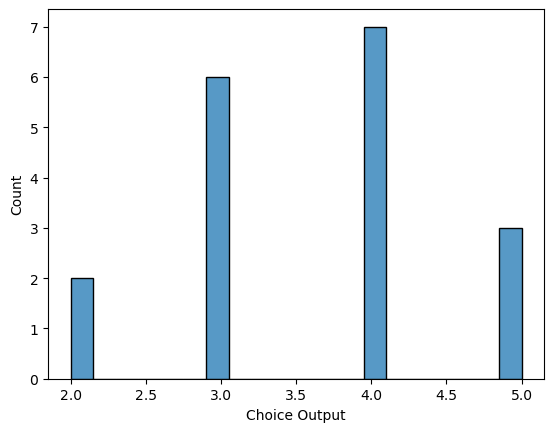

In [725]:
sns.histplot(data = lagged_scaled_data_sa78m1, x = "Choice Output", bins = 20)

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Choice Output', ylabel='Count'>

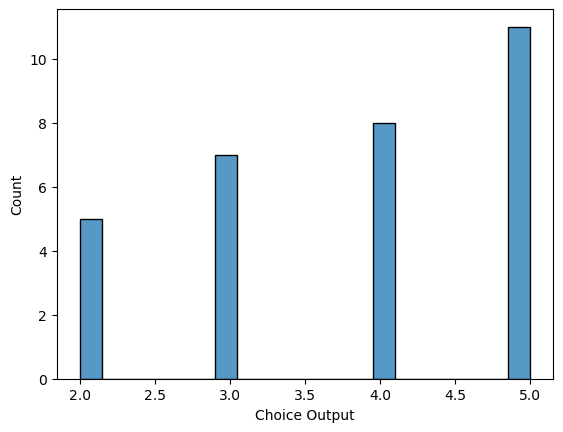

In [726]:
sns.histplot(data = lagged_scaled_data_sa78m3, x = "Choice Output", bins = 20)

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Choice Output', ylabel='Count'>

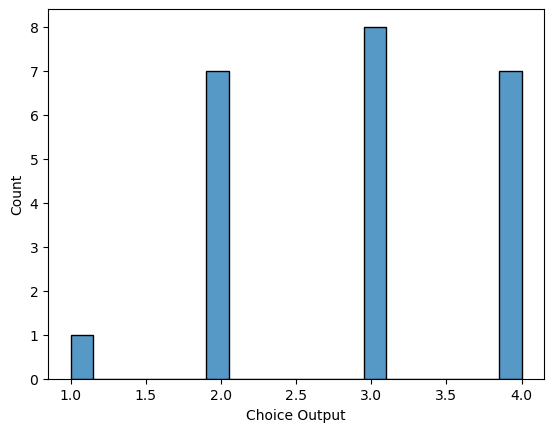

In [727]:
sns.histplot(data = lagged_scaled_data_sa88m1, x = "Choice Output", bins = 20)

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Choice Output', ylabel='Count'>

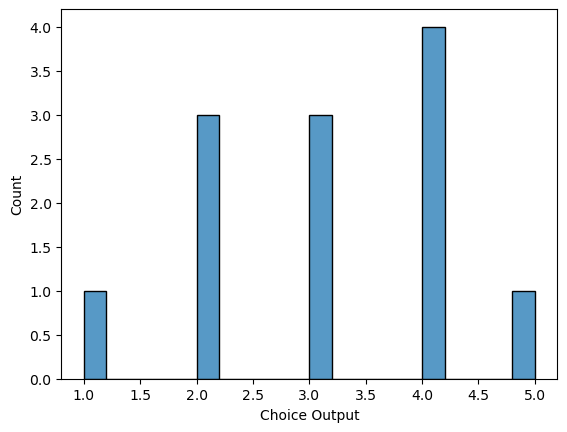

In [728]:
sns.histplot(data = lagged_scaled_data_sa190m1, x = "Choice Output", bins = 20)

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Choice Output', ylabel='Count'>

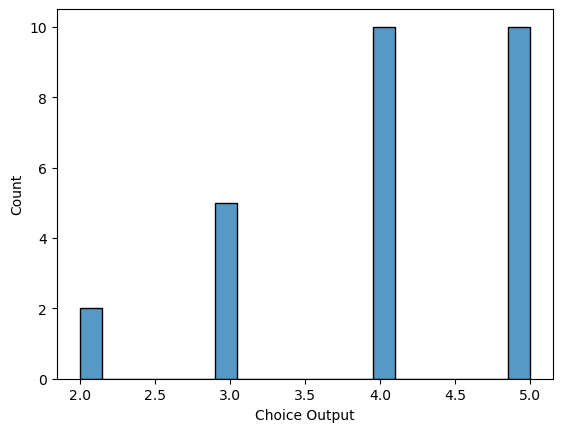

In [729]:
sns.histplot(data = lagged_scaled_data_sa78m5, x = "Choice Output", bins = 20)

In [740]:
grouped_lagged_scaled_data_pd = pd.concat([lagged_scaled_data_sa78m1_pd, lagged_scaled_data_sa78m3_pd, 
                            lagged_scaled_data_sa78m5_pd])

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lagged_1_duration', ylabel='Count'>

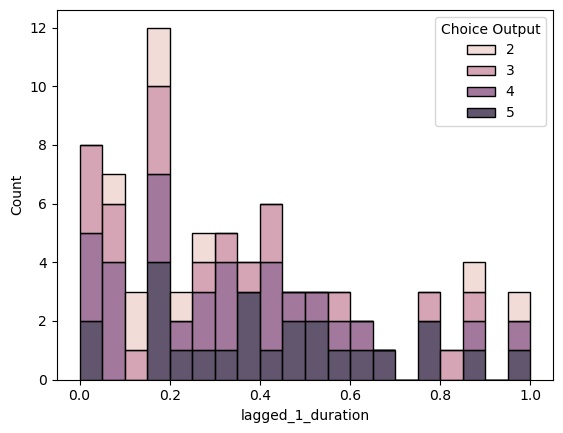

In [743]:
sns.histplot(data = grouped_lagged_scaled_data_pd, x = "lagged_1_duration", hue = "Choice Output", bins = 20, multiple = 'stack')

<Axes: xlabel='Middle Tail Velocity', ylabel='Choice Output'>

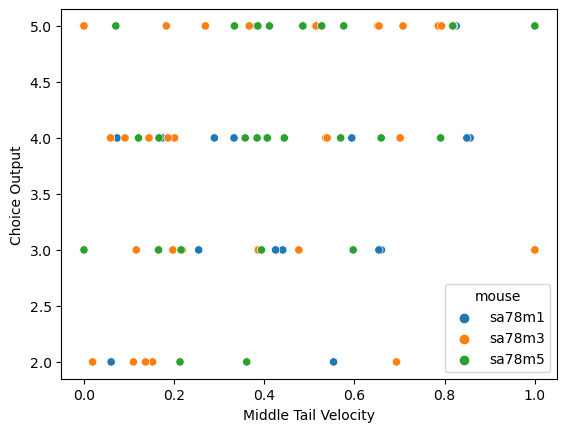

In [1652]:
sns.scatterplot(data = grouped_lagged_scaled_data_pd, x = "Middle Tail Velocity", y = "Choice Output", hue = "mouse")

In [715]:
grouped_lagged_scaled_data_pd.columns

Index(['Duration', 'lagged_1_duration', 'lagged_2_duration',
       'lagged_3_duration', 'lagged_4_duration', 'Entry Latency',
       'lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat', 'Exit Latency', 'lagged_1_exit_lat',
       'lagged_2_exit_lat', 'lagged_3_exit_lat', 'lagged_4_exit_lat',
       'Arm Nose Movement', 'lagged_1_arm_nose_mov', 'lagged_2_arm_nose_mov',
       'lagged_3_arm_nose_mov', 'lagged_4_arm_nose_mov', 'Arm Nose Velocity',
       'lagged_1_arm_nose_vel', 'lagged_2_arm_nose_vel',
       'lagged_3_arm_nose_vel', 'lagged_4_arm_nose_vel', 'Arm Tail Movement',
       'lagged_1_arm_tail_mov', 'lagged_2_arm_tail_mov',
       'lagged_3_arm_tail_mov', 'lagged_4_arm_tail_mov', 'Arm Tail Velocity',
       'lagged_1_arm_tail_vel', 'lagged_2_arm_tail_vel',
       'lagged_3_arm_tail_vel', 'lagged_4_arm_tail_vel', 'Middle Duration',
       'lagged_1_mid_duration', 'lagged_2_mid_duration',
       'lagged_3_mid_duration', 'lagged_4_mid_du

In [774]:
grouped_lagged_scaled_data_per = pl.concat([lagged_scaled_data_sa78m1, lagged_scaled_data_sa78m3, lagged_scaled_data_sa78m5], rechunk=True)

In [775]:
grouped_lagged_scaled_data_per

Duration,lagged_1_duration,lagged_2_duration,lagged_3_duration,lagged_4_duration,Entry Latency,lagged_1_entry_lat,lagged_2_entry_lat,lagged_3_entry_lat,lagged_4_entry_lat,Exit Latency,lagged_1_exit_lat,lagged_2_exit_lat,lagged_3_exit_lat,lagged_4_exit_lat,Arm Nose Movement,lagged_1_arm_nose_mov,lagged_2_arm_nose_mov,lagged_3_arm_nose_mov,lagged_4_arm_nose_mov,Arm Nose Velocity,lagged_1_arm_nose_vel,lagged_2_arm_nose_vel,lagged_3_arm_nose_vel,lagged_4_arm_nose_vel,Arm Tail Movement,lagged_1_arm_tail_mov,lagged_2_arm_tail_mov,lagged_3_arm_tail_mov,lagged_4_arm_tail_mov,Arm Tail Velocity,lagged_1_arm_tail_vel,lagged_2_arm_tail_vel,lagged_3_arm_tail_vel,lagged_4_arm_tail_vel,Middle Duration,lagged_1_mid_duration,…,lagged_3_mid_nose_vel,lagged_4_mid_nose_vel,Middle Tail Movement,lagged_1_mid_tail_mov,lagged_2_mid_tail_mov,lagged_3_mid_tail_mov,lagged_4_mid_tail_mov,Middle Tail Velocity,lagged_1_mid_tail_vel,lagged_2_mid_tail_vel,lagged_3_mid_tail_vel,lagged_4_mid_tail_vel,Current Coeff,lagged_1_cur_coeff,lagged_2_cur_coeff,lagged_3_cur_coeff,lagged_4_cur_coeff,Lagged 2 Coeff,lagged_1_coeff_2,lagged_2_coeff_2,lagged_3_coeff_2,lagged_4_coeff_2,Current Coeff Time Proportional,lagged_1_cur_coeff_time_prop,lagged_2_cur_coeff_time_prop,lagged_3_cur_coeff_time_prop,lagged_4_cur_coeff_time_prop,Lagged 2 Time Proportional,lagged_1_coeff_2_time_prop,lagged_2_coeff_2_time_prop,lagged_3_coeff_2_time_prop,lagged_4_coeff_2_time_prop,Choice Output,lagged_1_choice_ago,lagged_2_choice_ago,lagged_3_choice_ago,lagged_4_choice_ago
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64
0.020188,0.166218,0.010094,0.047779,0.098923,0.0,0.884615,0.461538,0.192308,0.0,0.246154,0.076923,0.292308,0.491803,0.333333,0.264968,0.357643,0.217816,0.259175,0.30422,0.903164,0.321935,0.895674,0.657483,0.516024,0.511125,0.543293,0.415624,0.482367,0.533361,1.0,0.345437,0.937047,0.725946,0.529948,0.031579,0.222222,…,0.373782,0.0,0.311882,0.0,0.063679,0.69027,0.0,0.825472,0.023571,0.215916,0.304232,0.0,0.665955,0.103433,0.027103,0.603231,0.0,0.0,0.0,0.577899,0.0,0.0,0.086973,0.119405,0.039084,0.577356,0.0,0.0,0.0,0.492284,0.0,0.0,5,4,3,2,1
0.03432,0.020188,0.166218,0.010094,0.047779,0.192308,0.0,0.884615,0.461538,0.4,0.492308,0.246154,0.076923,0.245902,0.483333,0.261909,0.264968,0.357643,0.217816,0.259175,0.764091,0.903164,0.321935,0.895674,0.727978,0.474897,0.511125,0.543293,0.415624,0.482367,0.812264,1.0,0.345437,0.937047,0.725946,0.021053,0.055556,…,0.357749,0.557966,0.073976,0.428059,0.0,0.063679,0.785612,0.59397,0.814269,0.023571,0.254845,0.456057,0.013828,0.665955,0.103433,0.027103,0.650582,0.495627,0.0,0.0,0.577899,0.0,0.005372,0.210826,0.119405,0.039084,0.588026,0.276545,0.0,0.0,0.492284,0.0,4,5,4,3,2
0.129206,0.03432,0.020188,0.166218,0.010094,0.038462,0.192308,0.0,0.884615,0.6,0.092308,0.492308,0.246154,0.016393,0.233333,0.413768,0.261909,0.264968,0.357643,0.217816,0.496108,0.764091,0.903164,0.321935,0.991706,0.520055,0.474897,0.511125,0.543293,0.415624,0.417565,0.812264,1.0,0.345437,0.937047,0.057895,0.037037,…,0.212092,0.546648,0.368369,0.144819,0.428059,0.0,0.3519,0.65986,0.567905,0.814269,0.027821,0.417446,0.624051,0.013828,0.665955,0.103433,0.14321,0.0,0.495627,0.0,0.0,0.577899,0.109088,0.013022,0.210826,0.119405,0.063343,0.0,0.276545,0.0,0.0,0.492284,3,4,5,4,3
0.182369,0.129206,0.03432,0.020188,0.166218,0.423077,0.038462,0.192308,0.0,0.914286,0.461538,0.092308,0.492308,0.196721,0.0,0.379217,0.413768,0.261909,0.264968,0.357643,0.306472,0.496108,0.764091,0.903164,0.356453,0.546556,0.520055,0.474897,0.511125,0.543293,0.315077,0.417565,0.812264,1.0,0.345437,0.084211,0.101852,…,1.0,0.443831,0.422522,0.495309,0.144819,0.428059,0.307823,0.553607,0.638025,0.567905,0.961078,0.239962,0.884537,0.624051,0.013828,0.665955,0.21043

In [782]:
X_grouped_per = grouped_lagged_scaled_data_per.drop("Choice Output")
y_grouped_per = grouped_lagged_scaled_data_per["Choice Output"]
print("X shape: {}\ny shape: {}".format(X_grouped_per.shape, y_grouped_per.shape))

X shape: (76, 84)
y shape: (76,)


In [783]:
X_train_per, X_test_per, y_train_per, y_test_per = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=42
)

In [315]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [785]:
# evaluate the model
model = GradientBoostingClassifier(max_depth=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train_per, y_train_per, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model.fit(X_train, y_train)
# make a single prediction
yhat = model.predict(X_test_per)
f1 = f1_score(y_test_per, yhat, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.272 (0.146)
F1 score: 0.774


In [786]:
yhat

array([3, 2, 4, 5, 1, 2, 3, 3, 4, 5, 4, 4, 3, 2, 5, 5], dtype=int64)

In [788]:
for y in y_test_per:
    print(y)

3
2
3
5
4
2
3
3
4
5
4
4
4
5
5
5


In [792]:
X_train_per2, X_test_per2, y_train_per2, y_test_per2 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=10
)

In [793]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [794]:
# evaluate the model
model2 = GradientBoostingClassifier(max_depth=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model2, X_train_per2, y_train_per2, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model2.fit(X_train_per2, y_train_per2)
# make a single prediction
yhat2 = model.predict(X_test_per2)
f1 = f1_score(y_test_per2, yhat2, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.300 (0.158)
F1 score: 1.000


In [795]:
yhat2

array([5, 4, 3, 2, 3, 5, 3, 2, 3, 3, 4, 3, 3, 3, 5, 5], dtype=int64)

In [796]:
for y in y_test_per2:
    print(y)

5
4
3
2
3
5
3
2
3
3
4
3
3
3
5
5


In [797]:
# evaluate the model
model2 = GradientBoostingClassifier(max_depth=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model2, X_train_per2, y_train_per2, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model2.fit(X_train_per2, y_train_per2)
# make a single prediction
yhat2 = model2.predict(X_test_per2)
f1 = f1_score(y_test_per2, yhat2, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.306 (0.150)
F1 score: 0.125


In [798]:
yhat2

array([5, 5, 4, 4, 5, 5, 5, 4, 5, 4, 5, 2, 4, 4, 3, 5], dtype=int64)

In [799]:
for y in y_test_per2:
    print(y)

5
4
3
2
3
5
3
2
3
3
4
3
3
3
5
5


In [800]:
X_train_per3, X_test_per3, y_train_per3, y_test_per3 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=25
)

In [801]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [802]:
# evaluate the model
model3 = GradientBoostingClassifier(max_depth=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model3, X_train_per3, y_train_per3, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model3.fit(X_train_per3, y_train_per3)
# make a single prediction
yhat3 = model.predict(X_test_per3)
f1 = f1_score(y_test_per3, yhat3, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.244 (0.127)
F1 score: 0.945


In [803]:
yhat3

array([5, 4, 5, 4, 2, 3, 3, 4, 4, 5, 5, 4, 2, 5, 3, 4], dtype=int64)

In [804]:
for y in y_test_per3:
    print(y)

5
4
5
4
2
3
3
4
4
5
5
4
5
5
3
4


In [822]:
y_grouped_per

Choice Output
i64
5
4
3
2
3
…
5
4
4


In [805]:
X_train_per4, X_test_per4, y_train_per4, y_test_per4 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=31
)

In [806]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [807]:
# evaluate the model
model4 = GradientBoostingClassifier(max_depth=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model4, X_train_per4, y_train_per4, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model4.fit(X_train_per4, y_train_per4)
# make a single prediction
yhat4 = model.predict(X_test_per4)
f1 = f1_score(y_test_per4, yhat4, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.278 (0.208)
F1 score: 0.929


In [808]:
yhat4

array([4, 5, 3, 3, 3, 2, 4, 5, 5, 3, 3, 3, 3, 5, 5, 3], dtype=int64)

In [809]:
for y in y_test_per4:
    print(y)

4
5
3
3
3
2
4
5
5
3
3
3
2
5
5
3


In [825]:
X_train_per5, X_test_per5, y_train_per5, y_test_per5 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=55
)

In [826]:
#min_samples_leaf smaller for less freq classes
#max_features generally sqroot of n of features, up to 30-40% n of features

In [827]:
# evaluate the model
model5 = GradientBoostingClassifier(max_depth=4)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model5, X_train_per5, y_train_per5, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model5.fit(X_train_per5, y_train_per5)
# make a single prediction
yhat5 = model5.predict(X_test_per5)
f1 = f1_score(y_test_per5, yhat5, average='weighted')
print('F1 score: %.3f' % (f1))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Accuracy: 0.317 (0.189)
F1 score: 0.248


In [932]:
# changing number of trees - estimators
def get_models_est():
	models = dict()
	# define number of trees to consider
	n_trees = [5, 10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = GradientBoostingClassifier(n_estimators=n, max_depth=4)
	return models

In [933]:
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [934]:
models_est =  get_models_est()

In [935]:
results_est=[]
names_est=[]

>5 0.301 (0.057)
>10 0.330 (0.035)
>50 0.381 (0.010)
>100 0.390 (0.048)
>500 0.373 (0.045)
>1000 0.368 (0.055)
>5000 0.353 (0.049)


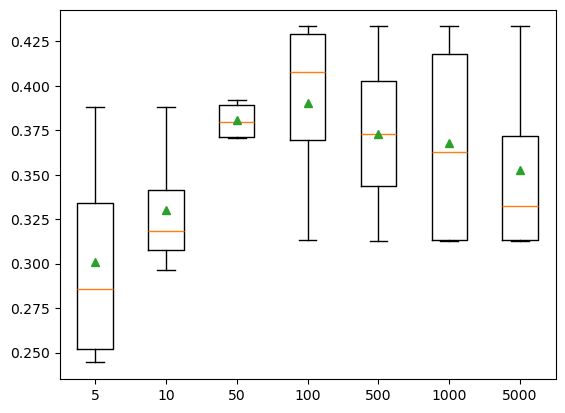

In [936]:
for name, model in models_est.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_per5, y_train_per5)
	# store the results
	results_est.append(scores)
	names_est.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_est, labels=names_est, showmeans=True)
pyplot.show()

In [937]:
def get_models_subs():
	models = dict()
	# explore sample ratio from 10% to 100% in 10% increments
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = GradientBoostingClassifier(subsample=i, n_estimators=100, max_depth=4)
	return models

In [938]:
models_subs =  get_models_subs()

In [939]:
results_subs=[]
names_subs=[]

>0.1 0.243 (0.179)
>0.2 0.186 (0.057)
>0.3 0.254 (0.088)
>0.4 0.223 (0.050)
>0.5 0.276 (0.089)
>0.6 0.262 (0.061)
>0.7 0.233 (0.063)
>0.8 0.245 (0.091)
>0.9 0.295 (0.058)
>1.0 0.393 (0.027)


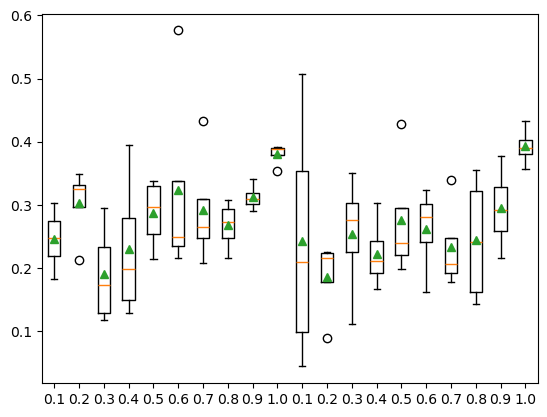

In [941]:
for name, model in models_subs.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_per5, y_train_per5)
	# store the results
	results_subs.append(scores)
	names_subs.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_subs, labels=names_subs, showmeans=True)
pyplot.show()

In [947]:
def get_models_feat():
    models = dict()
	# explore number of features from 1 to 20
    l = [5,10,20,30,40,50,60,70,80,84];
    for i in l:
        models[str(i)] = GradientBoostingClassifier(max_features=i, n_estimators=100, max_depth=4)
    return models

In [948]:
models_feat = get_models_feat()

In [949]:
results_feat=[]
names_feat=[]

>5 0.277 (0.062)
>10 0.320 (0.114)
>20 0.294 (0.076)
>30 0.325 (0.023)
>40 0.372 (0.103)
>50 0.309 (0.009)
>60 0.362 (0.066)
>70 0.339 (0.036)
>80 0.396 (0.059)
>84 0.381 (0.043)


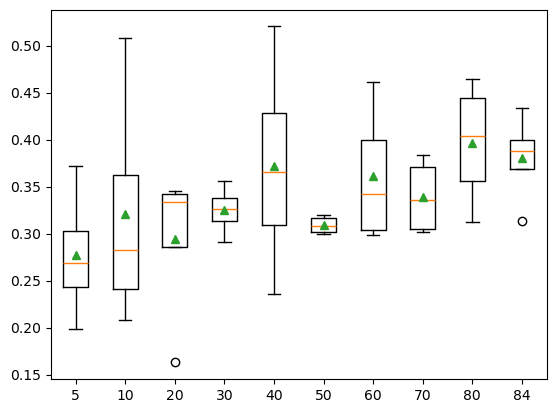

In [950]:
for name, model in models_feat.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_per5, y_train_per5)
	# store the results
	results_feat.append(scores)
	names_feat.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_feat, labels=names_feat, showmeans=True)
pyplot.show()

In [1027]:
def get_models_lr():
	models = dict()
	# define learning rates to explore
	for i in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
		key = '%.4f' % i
		models[key] = GradientBoostingClassifier(learning_rate=i, n_estimators=100, max_depth=4)
	return models

In [1028]:
models_lr = get_models_lr()

In [1029]:
results_lr=[]
names_lr=[]

>0.3000 0.335 (0.068)
>0.4000 0.397 (0.088)
>0.5000 0.359 (0.109)
>0.6000 0.268 (0.045)
>0.7000 0.311 (0.093)
>0.8000 0.280 (0.088)
>0.9000 0.308 (0.011)
>1.0000 0.302 (0.103)


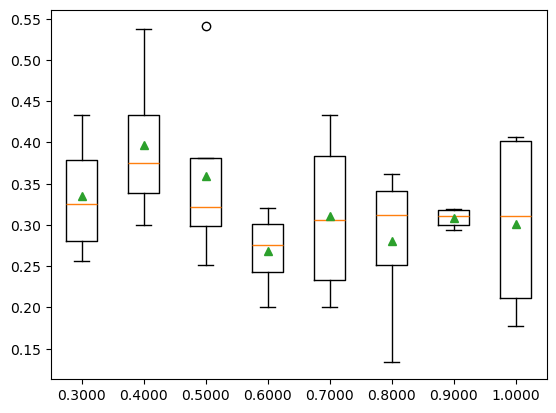

In [1030]:
for name, model in models_lr.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_per5, y_train_per5)
	# store the results
	results_lr.append(scores)
	names_lr.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_lr, labels=names_lr, showmeans=True)
pyplot.show()

In [845]:
def get_models_td():
	models = dict()
	# define max tree depths to explore between 1 and 10
	for i in range(1,8):
		models[str(i)] = GradientBoostingClassifier(max_depth=i)
	return models

In [846]:
models_td = get_models_td()

In [847]:
results_td=[]
names_td=[]

>1 0.302 (0.126)
>2 0.304 (0.114)
>3 0.274 (0.146)
>4 0.289 (0.092)
>5 0.283 (0.171)
>6 0.311 (0.184)
>7 0.309 (0.203)


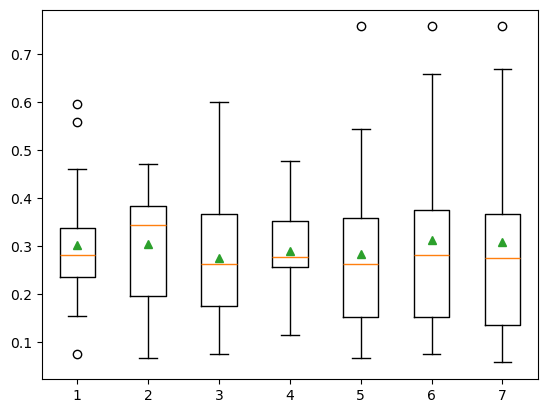

In [848]:
for name, model in models_td.items():
	# evaluate the model
	scores = evaluate_model(model, X_train_per5, y_train_per5)
	# store the results
	results_td.append(scores)
	names_td.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_td, labels=names_td, showmeans=True)
pyplot.show()

In [400]:
md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_features=10, max_depth=5, random_state=42)
scores = evaluate_model(md, X_train, y_train)
# store the results
results_td.append(scores)
names_td.append(name)
# summarize the performance along the way
print('%.3f (%.3f)' % (mean(scores), std(scores)))

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


0.340 (0.159)


In [912]:
def get_kfolds_split():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,10):
        #cvs[str(i)] = RepeatedStratifiedKFold(n_splits=i, n_repeats=1, random_state=1)
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=i, random_state=1)
    return cvs

In [913]:
results_ksp = []
names_ksp = []

In [914]:
cvs_split = get_kfolds_split()

>2 0.288 (0.083)
>3 0.282 (0.086)
>4 0.291 (0.098)
>5 0.313 (0.134)
>6 0.302 (0.142)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  

>7 0.300 (0.156)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=8.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=8.
  

>8 0.298 (0.146)


C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  warnings.warn(
C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=9.
  

>9 0.285 (0.152)


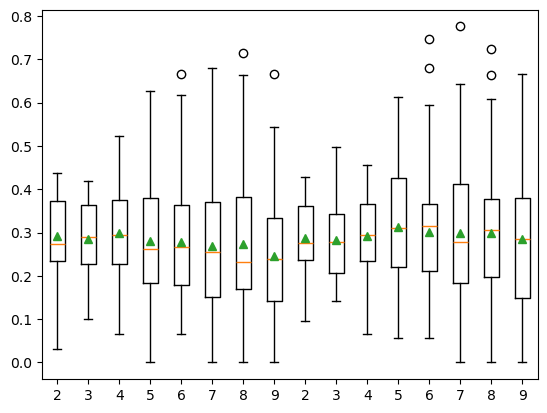

In [916]:
for name, cv in cvs_split.items():
	# evaluate the model
    #md =  GradientBoostingClassifier(learning_rate = 0.15, n_estimators=500, max_features=26, max_depth=5, random_state=42)
    md =  GradientBoostingClassifier(max_depth=5)
    scores = cross_val_score(md, X_train_per5, y_train_per5, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
	# store the results
    results_ksp.append(scores)
    names_ksp.append(name)
	# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_ksp, labels=names_ksp, showmeans=True)
pyplot.show()

In [858]:
def get_kfolds_repeat():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,15):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=4, n_repeats=i, random_state=1)
    return cvs

In [859]:
results_kr = []
names_kr = []

In [860]:
cvs_r = get_kfolds_repeat()

>2 0.353 (0.082)
>3 0.320 (0.083)
>4 0.318 (0.113)
>5 0.299 (0.118)
>6 0.292 (0.093)
>7 0.314 (0.106)
>8 0.307 (0.112)
>9 0.296 (0.101)
>10 0.290 (0.099)
>11 0.289 (0.103)
>12 0.295 (0.111)
>13 0.295 (0.100)
>14 0.306 (0.116)


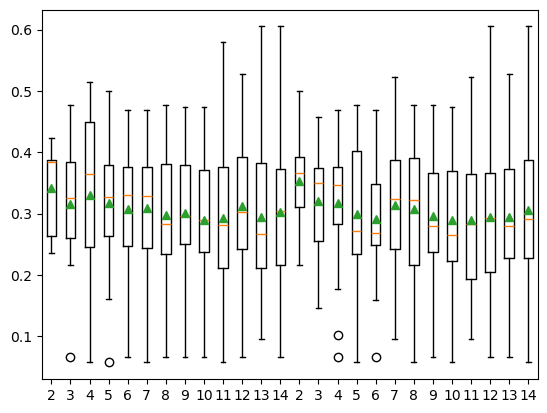

In [862]:
for name, cv in cvs_r.items():
	# evaluate the model
    md =  GradientBoostingClassifier()
    scores = cross_val_score(md, X_train_per5, y_train_per5, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
	# store the results
    results_kr.append(scores)
    names_kr.append(name)
	# summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results_kr, labels=names_kr, showmeans=True)
pyplot.show()

In [ ]:
def get_crossval_repeat():
    cvs = dict()
	# define max tree depths to explore between 1 and 10
    for i in range(2,15):
        cvs[str(i)] = RepeatedStratifiedKFold(n_splits=16, n_repeats=i, random_state=1)
    return cvs

In [502]:
for i in y_train:
    if i == 1:
        print(i)

1


In [503]:
for i in y_test:
    if i == 1:
        print(i)

1


In [1032]:
X_train_per7, X_test_per7, y_train_per7, y_test_per7 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=150
)

In [1041]:
# evaluate the model
mod = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.5)
#cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
#n_scores = cross_val_score(mod, X_train_per7, y_train_per7, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
mod = GradientBoostingClassifier(n_estimators = 100, max_depth=4, learning_rate=0.5)
mod.fit(X_train_per7, y_train_per7)
# make a single prediction
yhat7 = mod.predict(X_test_per7)

In [1042]:
yhat7

array([3, 3, 5, 4, 4, 5, 5, 4, 4, 5, 3, 5, 3, 4, 4, 3], dtype=int64)

In [1043]:
for y in y_test_per7:
    print(y)

4
2
4
5
3
5
5
3
2
5
4
5
4
3
3
5


In [517]:
yhat

array([4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 4, 3, 5, 3, 2, 5, 3, 4, 4, 5, 3, 3],
      dtype=int64)

In [1141]:
X_pd = grouped_lagged_scaled_data_pd.drop(columns =['Choice Output','mouse'])
#y_pd = grouped_lagged_scaled_data_pd['Choice Output']

In [1142]:
X_pd = X_pd.iloc[:,:].values
y_pd = grouped_lagged_scaled_data_pd.iloc[:,80].values

In [1143]:
X_trainpd1, X_testpd1, y_trainpd1, y_testpd1 = train_test_split(X_pd, y_pd, test_size = 0.2, random_state = 21)

In [1144]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_trainpd1, y_trainpd1)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_testpd1)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
#reversefactor = dict(zip(range(3),definitions))
#y_test = np.vectorize(reversefactor.get)(y_test)
#y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
#print(pd.crosstab(y_test, y_pred, rownames=['Actual Species'], colnames=['Predicted Species']))

In [1145]:
print(f1_score(y_testpd1, y_pred, average = 'weighted'))

0.24166666666666667


In [1435]:
grouped_lagged_scaled_data_pd.columns

Index(['Duration', 'lagged_1_duration', 'lagged_2_duration',
       'lagged_3_duration', 'lagged_4_duration', 'Entry Latency',
       'lagged_1_entry_lat', 'lagged_2_entry_lat', 'lagged_3_entry_lat',
       'lagged_4_entry_lat', 'Exit Latency', 'lagged_1_exit_lat',
       'lagged_2_exit_lat', 'lagged_3_exit_lat', 'lagged_4_exit_lat',
       'Arm Nose Movement', 'lagged_1_arm_nose_mov', 'lagged_2_arm_nose_mov',
       'lagged_3_arm_nose_mov', 'lagged_4_arm_nose_mov', 'Arm Nose Velocity',
       'lagged_1_arm_nose_vel', 'lagged_2_arm_nose_vel',
       'lagged_3_arm_nose_vel', 'lagged_4_arm_nose_vel', 'Arm Tail Movement',
       'lagged_1_arm_tail_mov', 'lagged_2_arm_tail_mov',
       'lagged_3_arm_tail_mov', 'lagged_4_arm_tail_mov', 'Arm Tail Velocity',
       'lagged_1_arm_tail_vel', 'lagged_2_arm_tail_vel',
       'lagged_3_arm_tail_vel', 'lagged_4_arm_tail_vel', 'Middle Duration',
       'lagged_1_mid_duration', 'lagged_2_mid_duration',
       'lagged_3_mid_duration', 'lagged_4_mid_du

In [1387]:
from sklearn.decomposition import PCA

In [1530]:
x_p2 = grouped_lagged_scaled_data_pd.drop(columns=['Duration',
       'lagged_4_entry_lat', 'Exit Latency',
       'Arm Nose Movement', 'Arm Nose Velocity', 'Arm Tail Movement', 'Arm Tail Velocity', 'lagged_4_mid_duration',
       'lagged_4_mid_nose_mov', 'lagged_4_mid_nose_vel',
       'lagged_4_mid_tail_mov', 'lagged_4_mid_tail_vel',
       'lagged_4_cur_coeff', 'Lagged 2 Coeff', 'lagged_1_coeff_2',
       'lagged_2_coeff_2', 'lagged_3_coeff_2', 'lagged_4_coeff_2',
       'lagged_4_cur_coeff_time_prop', 'Lagged 2 Time Proportional',
       'lagged_1_coeff_2_time_prop', 'lagged_2_coeff_2_time_prop',
       'lagged_3_coeff_2_time_prop', 'lagged_4_coeff_2_time_prop',
       'Choice Output', 'lagged_1_choice_ago', 'lagged_2_choice_ago',
       'lagged_3_choice_ago', 'lagged_4_choice_ago', 'mouse']).iloc[:,:].values
y_p = grouped_lagged_scaled_data_pd.iloc[:,80].values

In [1580]:
pca = PCA(n_components = 2)
x_pca = pca.fit_transform(x_p)

In [1573]:
help(pca)

Help on PCA in module sklearn.decomposition._pca object:

class PCA(sklearn.decomposition._base._BasePCA)
 |  PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)
 |  
 |  Principal component analysis (PCA).
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  


In [1581]:
pca.explained_variance_ratio_

array([0.22175668, 0.13740886])

In [1582]:
pca = PCA()
x_pca = pca.fit_transform(x_p)

In [1583]:
pca.explained_variance_ratio_

array([2.21756682e-01, 1.37408860e-01, 8.00464977e-02, 5.83106571e-02,
       5.15461344e-02, 4.80335153e-02, 3.57188150e-02, 3.46460219e-02,
       3.05128773e-02, 2.73559939e-02, 2.40759040e-02, 2.30478848e-02,
       1.92278687e-02, 1.72293457e-02, 1.60331752e-02, 1.51585132e-02,
       1.40093733e-02, 1.36873994e-02, 1.14179016e-02, 1.03337051e-02,
       9.68037292e-03, 8.85392387e-03, 8.33314772e-03, 7.95731436e-03,
       7.48349384e-03, 6.83102003e-03, 5.67795113e-03, 5.01769593e-03,
       4.85928939e-03, 4.59716587e-03, 4.43331368e-03, 3.69582122e-03,
       3.28494265e-03, 2.97607700e-03, 2.90427678e-03, 2.67053393e-03,
       2.35656254e-03, 2.22717917e-03, 1.95529215e-03, 1.47166999e-03,
       1.44811740e-03, 1.24399409e-03, 1.17894264e-03, 1.15381479e-03,
       8.99067305e-04, 8.55894705e-04, 7.87574921e-04, 7.04017249e-04,
       6.84903620e-04, 5.26124828e-04, 4.54342993e-04, 3.75596858e-04,
       3.63920681e-04, 3.30453363e-04, 3.05725743e-04, 2.68571552e-04,
      

In [1423]:
pca_df = pd.DataFrame(data=x_pca, columns=['Principal Component 1', 'Principal Component 2'])

In [1424]:
pca_df['Target'] = y_p

<Axes: xlabel='Principal Component 1', ylabel='Principal Component 2'>

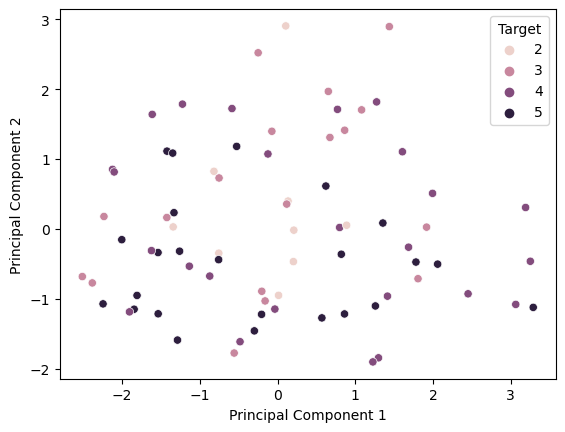

In [1426]:
sns.scatterplot(data = pca_df, x = 'Principal Component 1', y = 'Principal Component 2', hue = 'Target')

In [1556]:
pca2 = PCA(  svd_solver='full')
x_pca2 = pca2.fit_transform(x_p2)

In [1545]:
pca_df2 = pd.DataFrame(data=x_pca, columns=['Principal Component 1', 'Principal Component 2'])

In [1542]:
pca_df2['Target'] = y_p

In [1546]:
pca_df2.head

<bound method NDFrame.head of            0         1         2         3         4         5         6
0   0.439721 -0.453926  0.702694  0.053457 -0.546844  0.378137 -0.576824
1  -0.129806 -0.612055  0.730154 -0.256477 -0.560287 -0.186914  0.182051
2  -0.210172 -0.850078  0.314599 -0.013516 -0.837773 -0.436149  0.167049
3  -0.247270 -0.667168  0.135283 -0.545104 -0.524176  0.090187 -0.198185
4  -0.443522 -0.236998  0.190185 -0.485478 -0.595024  0.413832  0.200489
..       ...       ...       ...       ...       ...       ...       ...
71 -0.889609 -0.640537  0.044720 -0.532369  0.836043  0.733616 -0.206143
72 -0.394082 -0.553356 -0.424969 -0.185343  1.118042 -0.186925  0.209604
73 -0.393753 -0.056370 -0.683815 -0.447778  0.507016 -0.256273 -0.642293
74 -0.192580  0.388877 -0.344731 -0.449309  0.337454 -0.812974 -0.194325
75 -0.082158  0.339162 -0.367388  0.280398 -0.408880 -0.468933  0.546402

[76 rows x 7 columns]>

In [1543]:
sns.scatterplot(data = pca_df2, x = 'Principal Component 1', y = 'Principal Component 2', hue = 'Target')

ValueError: Could not interpret value `Principal Component 1` for parameter `x`

In [1593]:
x_km = grouped_lagged_scaled_data_pd.drop(columns = ['Choice Output', 'mouse', 'Duration', ])

In [1607]:
x_kma = x_km.iloc[:,:].values

In [1619]:
y_kma = grouped_lagged_scaled_data_pd.iloc[:,80].values

In [1612]:
from sklearn.cluster import k_means
from sklearn.cluster import KMeans

In [1613]:
kmeans = KMeans(n_clusters = 4, random_state=0, n_init = "auto").fit(x_kma)

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [1616]:
kmeans.labels_

array([1, 1, 2, 3, 3, 3, 1, 1, 1, 2, 3, 3, 1, 1, 2, 3, 3, 2, 1, 1, 1, 3,
       3, 1, 1, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 0,
       0, 3, 2, 2, 3, 1, 1, 2, 3, 3, 1, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 0,
       3, 2, 1, 2, 2, 0, 2, 0, 0, 2])

In [1525]:
tsne = TSNE(n_components=2, random_state=42)

In [1568]:
help(tsne)


Help on TSNE in module sklearn.manifold._t_sne object:

class TSNE(sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None, square_distances='deprecated')
 |  
 |  T-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedS

In [1624]:
x_tsne = tsne.fit_transform(x_kma)

In [1625]:
tsne_df = pd.DataFrame(data=x_tsne, columns= ['TSNE Component 1', 'TSNE Component 2'])

In [1626]:
tsne_df['Target']=y_kma

In [1629]:
tsne_df['Labels'] = kmeans.labels_

<Axes: xlabel='TSNE Component 1', ylabel='TSNE Component 2'>

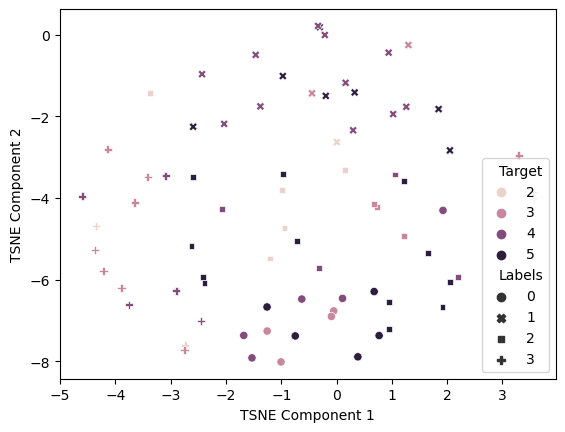

In [1632]:
sns.scatterplot(data = tsne_df, x = 'TSNE Component 1', y = 'TSNE Component 2', hue = 'Target', style = 'Labels')

In [1611]:
#centroid, label, inertia = k_means(x_kma, n_clusters=2, n_init="auto", random_state=0)

C:\Users\Josue Regalado\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
k_means.fit

In [1587]:
X_pd

array([[0.02018843, 0.16621803, 0.01009421, ..., 3.        , 2.        ,
        1.        ],
       [0.03432032, 0.02018843, 0.16621803, ..., 4.        , 3.        ,
        2.        ],
       [0.12920592, 0.03432032, 0.02018843, ..., 5.        , 4.        ,
        3.        ],
       ...,
       [0.26455026, 0.09589041, 0.61986301, ..., 5.        , 4.        ,
        4.        ],
       [0.27513228, 0.2859589 , 0.09589041, ..., 4.        , 5.        ,
        4.        ],
       [0.52910053, 0.29623288, 0.2859589 , ..., 4.        , 4.        ,
        5.        ]])

In [1407]:
from sklearn.manifold import TSNE

In [1525]:
tsne = TSNE(n_components=2, random_state=42)

In [1568]:
help(tsne)


Help on TSNE in module sklearn.manifold._t_sne object:

class TSNE(sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None, square_distances='deprecated')
 |  
 |  T-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedS

In [1531]:
x_tsne = tsne.fit_transform(x_p2)

In [1532]:
tsne_df = pd.DataFrame(data=x_tsne, columns= ['TSNE Component 1', 'TSNE Component 2'])

In [1533]:
tsne_df['Target']=y_p

<Axes: xlabel='TSNE Component 1', ylabel='TSNE Component 2'>

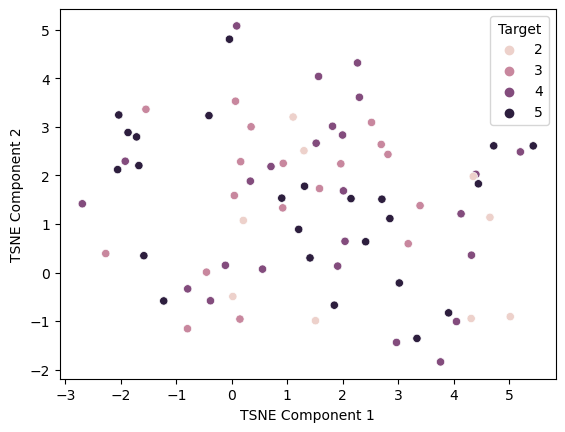

In [1534]:
sns.scatterplot(data = tsne_df, x = 'TSNE Component 1', y = 'TSNE Component 2', hue = 'Target')

In [828]:
yhat5

array([3, 4, 4, 5, 3, 2, 4, 5, 5, 2, 4, 5, 2, 3, 4, 5], dtype=int64)

In [829]:
for y in y_test_per5:
    print(y)

5
3
2
3
3
4
4
3
5
3
5
4
2
4
3
2


In [1045]:
from sklearn.ensemble import AdaBoostClassifier

In [1046]:
from sklearn import metrics

In [1102]:
X_train_per8, X_test_per8, y_train_per8, y_test_per8 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=10
)

In [1159]:
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1, random_state=50)
clf.fit(X_trainpd1, y_trainpd1)

AdaBoostClassifier(learning_rate=1, random_state=50)

In [1160]:
y_pred = clf.predict(X_testpd1)

In [1161]:
y_pred

array([4, 5, 5, 4, 4, 5, 3, 5, 5, 4, 4, 4, 5, 5, 4, 5], dtype=int64)

In [1162]:
y_testpd1

array([2, 3, 3, 3, 3, 5, 4, 4, 5, 4, 3, 3, 5, 5, 5, 2], dtype=int64)

In [1163]:
print(f1_score(y_testpd1, y_pred, average = 'weighted'))

0.22980769230769232


In [1106]:
from sklearn.ensemble import RandomForestClassifier

In [1218]:
X_train_per9, X_test_per9, y_train_per9, y_test_per9 = train_test_split(
    X_grouped_per, y_grouped_per, test_size=0.2, random_state=10
)

In [1235]:
rf = RandomForestClassifier(n_estimators=100, random_state=25, n_jobs = -1, class_weight = "balanced")
rf.fit(X_trainpd1, y_trainpd1)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=25)

In [1236]:
y_predf = rf.predict(X_testpd1)

In [1237]:
print(f1_score(y_testpd1, y_predf, average = 'weighted'))

0.3125


In [1116]:
X_train_per9[:,:].values

AttributeError: 'DataFrame' object has no attribute 'values'

In [ ]:
class_weight = "balanced"

In [1239]:
y_predf

array([4, 3, 4, 4, 4, 4, 3, 5, 5, 4, 4, 4, 4, 5, 5, 5], dtype=int64)

In [1238]:
y_testpd1

array([2, 3, 3, 3, 3, 5, 4, 4, 5, 4, 3, 3, 5, 5, 5, 2], dtype=int64)

In [1349]:
mdp = GradientBoostingClassifier(n_estimators = 10000, learning_rate=0.1)
#cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2, random_state=1)
#n_scores = cross_val_score(mdp, X_trainpd1, y_trainpd1, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
mdp.fit(X_trainpd1, y_trainpd1, sample_weight = 1)
# make a single prediction
yhatpd = mdp.predict(X_testpd1)
f1 = f1_score(y_testpd1, yhatpd, average='weighted')
print('F1 score: %.3f' % (f1))

SyntaxError: positional argument follows keyword argument (2332929841.py, line 6)

In [1345]:
y_testpd1

array([2, 3, 3, 3, 3, 5, 4, 4, 5, 4, 3, 3, 5, 5, 5, 2], dtype=int64)

In [1346]:
yhatpd

array([2, 2, 4, 4, 2, 4, 3, 5, 5, 3, 4, 3, 4, 3, 2, 2], dtype=int64)

In [1347]:
from sklearn.metrics import confusion_matrix

In [1348]:
confusion_matrix(y_testpd1, yhatpd)

array([[2, 0, 0, 0],
       [2, 1, 3, 0],
       [0, 2, 0, 1],
       [1, 1, 2, 1]], dtype=int64)

# shap feature importance

In [810]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [811]:
import shap

In [1044]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test_per3)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: GradientBoostingClassifier(learning_rate=1.0, max_depth=4)

In [1314]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [1315]:
mlr = LogisticRegression()

In [1317]:
ovr =OneVsRestClassifier(mlr)

In [1318]:
ovr.fit(X_trainpd1, y_trainpd1)

OneVsRestClassifier(estimator=LogisticRegression())

In [1319]:
yhatovr = ovr.predict(X_testpd1)

In [1320]:
yhatovr

array([4, 3, 4, 4, 4, 5, 3, 5, 4, 5, 4, 4, 4, 5, 5, 5], dtype=int64)

In [1312]:
y_testpd1

array([2, 3, 3, 3, 3, 5, 4, 4, 5, 4, 3, 3, 5, 5, 5, 2], dtype=int64)

In [1321]:
f1 = f1_score(y_testpd1, yhatovr, average='weighted')
print('F1 score: %.3f' % (f1))

F1 score: 0.264


In [1350]:
from sklearn.neural_network import MLPClassifier

In [1365]:
mlp = MLPClassifier(random_state=2, max_iter=10000, learning_rate='adaptive').fit(X_trainpd1, y_trainpd1)

In [1366]:
mlp.predict_proba(X_testpd1)

array([[1.23900112e-02, 1.08102094e-02, 9.76743919e-01, 5.58604009e-05],
       [3.76727271e-05, 9.96081396e-01, 7.26021003e-04, 3.15490993e-03],
       [2.50193315e-02, 2.79107800e-04, 9.74439771e-01, 2.61789947e-04],
       [5.06395605e-01, 2.13861828e-01, 2.47058055e-01, 3.26845125e-02],
       [3.61765118e-02, 9.10411306e-03, 5.32248939e-01, 4.22470436e-01],
       [1.11986830e-04, 8.69075351e-02, 3.06578252e-01, 6.06402226e-01],
       [3.00119916e-03, 9.92003622e-01, 4.87524915e-03, 1.19929934e-04],
       [5.20749954e-03, 7.81179605e-01, 2.44614676e-03, 2.11166748e-01],
       [1.72692503e-03, 2.47630335e-02, 8.74205153e-01, 9.93048885e-02],
       [1.51917431e-02, 1.33207665e-01, 9.53859469e-02, 7.56214645e-01],
       [6.46054957e-01, 3.61699613e-04, 3.34878270e-01, 1.87050738e-02],
       [8.08684019e-01, 7.00756184e-02, 1.21235522e-01, 4.83995608e-06],
       [2.30023674e-03, 4.70866367e-04, 9.97193750e-01, 3.51466573e-05],
       [2.67214284e-02, 1.28907024e-02, 2.61167149e

In [1367]:
mlp.predict(X_testpd1)

array([4, 3, 4, 2, 4, 5, 3, 3, 4, 5, 2, 2, 4, 5, 5, 5], dtype=int64)

In [1356]:
y_testpd1

array([2, 3, 3, 3, 3, 5, 4, 4, 5, 4, 3, 3, 5, 5, 5, 2], dtype=int64)

In [1368]:
mlp.score(X_testpd1, y_testpd1)

0.25

# gridsearch cv

In [1536]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
param_grid1 = {'n_estimators' = [2,4,8,32,64,128, 256, 512],
                'max_depth' = [None, 2,3,4,5,6,7,8],
                'min_samples_split' = [2, 4, 8],
                'learning_rate' = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0],
                'min_samples_leaf' = [1,2,4,8],
                '' = [],
}

In [ ]:
search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring ='f1_micro')